# Projet 1 :  Analyse et Synthèse de texte sur le dataset TALN

Ce travail a été effectué par :


*   Axel THEVENOT
*   Julien PYTEL


## Objectifs

Le but du projet est d'utiliser une synthèse de données textuelles d'un grand nombre d'articles scientifiques sur le traitement du langage naturel.
Le jeu de données TALN n'est pas vraiment grand, juste 44Mo, mais il est assez grand pour être trop compliqué pour être traité à la main. 
La manière de générer la synthèse et le type de synthèse sont totalement ouverts ! 
Nous pouvons nous concentrer sur les résumés ou les titres (moins d'effort de calcul) ou sélectionner un sous-ensemble spécifique. 
Si une approche ne fonctionne pas comme prévu, vous pouvez le montrer et l'expliquer. 
Ce projet contiendra un rapport pour expliquer la logique de nos approches et de nos résultats.

Dataset (44Mo) : https://www.ortolang.fr/market/corpora/corpus-taln

## Import packages et Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
root = '/content/drive/MyDrive/'
root += 'A5/Advanced Machine Learning for Big Data and Text Processing/project1'

In [3]:
%%capture
%matplotlib inline
# system
import os
# regular expressions
import re
# xml trees (our dataset)
import xml.etree.ElementTree as ET
# data encoding
import unicodedata as ucd
# avoid warnings
import warnings
warnings.filterwarnings("ignore")

# deal with data
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 50)  # default = 50
# display data
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [11, 4]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 7.5 # default = 10.0
# easy access
plt.default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# sklearn for vectorization on tfidf and K-Means (unsupervised clusterization)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# beautiful visualization of clusters
from wordcloud import WordCloud


# Natural Langage Processing
import nltk
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

# to use the lemmatization package and its french and english vocabulary
import spacy 
!pip install spacy
!python3 -m spacy download fr
!python3 -m spacy download en

# to perform and visualize LDA
! pip install pyldavis
import gensim
import pyLDAvis.gensim
pyLDAvis.enable_notebook()


# create a saving directory
save_dir = os.path.join(root, 'save_dir')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# to export the notebook
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

## Import du dataset TALN
### Format XML

In [4]:
corpus_filepath = os.path.join(root, 'corpus-taln/2/corpus_taln_v1.tei.xml')
corpus_tree = ET.parse(corpus_filepath)
corpus_root = corpus_tree.getroot()
corpus_root.findall('./')[:7]

[<Element '{http://www.tei-c.org/ns/1.0}teiHeader' at 0x7f71f0ee8958>,
 <Element '{http://www.tei-c.org/ns/1.0}TEI' at 0x7f71f0e798b8>,
 <Element '{http://www.tei-c.org/ns/1.0}TEI' at 0x7f71f0e8c1d8>,
 <Element '{http://www.tei-c.org/ns/1.0}TEI' at 0x7f71f0e95688>,
 <Element '{http://www.tei-c.org/ns/1.0}TEI' at 0x7f71f0e9b4a8>,
 <Element '{http://www.tei-c.org/ns/1.0}TEI' at 0x7f71f0eab638>,
 <Element '{http://www.tei-c.org/ns/1.0}TEI' at 0x7f71f0e3cd68>]

On voit qu'il existe des namespaces qui ne rendent pas la lecture et l'écriture facile alors nous allons nous créer un dictionnaire de ces namespaces pour le confort de tout le monde

In [5]:
ns = {
    "tal": "http://www.tei-c.org/ns/1.0",
    "xml": "http://www.w3.org/XML/1998/namespace"
}

Première vérification qui va déterminer la suite de notre étude. On regarde le nombre de publication, celles dont la langue est renseignée, celles en français et celles en anglais

In [6]:
print(
    'Nombre de publication :', 
    len(corpus_root.findall('./tal:TEI', namespaces=ns))
)
print(
    'Nombre de publication avec la langue renseignée :',
     len(corpus_root.findall('./tal:TEI[@xml:lang]', ns))
)
print(
    'Nombre de publication en francais :',
     len(corpus_root.findall('./tal:TEI[@xml:lang="fr"]', ns))
)
print(
    'Nombre de publication en anglais :',
     len(corpus_root.findall('./tal:TEI[@xml:lang="en"]', ns))
)


Nombre de publication : 1602
Nombre de publication avec la langue renseignée : 1602
Nombre de publication en francais : 1502
Nombre de publication en anglais : 100


On peut alors se dire que l'on va faire notre étude de texte sur les publications en français si on étudie les publications dans leur entièreté. 

In [7]:
print(
    'Nombre de publication avec abstract en francais :', 
    len(corpus_root.findall('./tal:TEI/tal:text/tal:front/tal:div[@type="abstract"][@xml:lang="fr"]', namespaces=ns))
)
print(
    'Nombre de publication avec abstract en anglais :', 
    len(corpus_root.findall('./tal:TEI/tal:text/tal:front/tal:div[@type="abstract"][@xml:lang="en"]', namespaces=ns))
)
print(
    'Nombre de publication avec keywords en francais :', 
    len(corpus_root.findall('./tal:TEI/tal:text/tal:front/tal:div[@type="keywords"][@xml:lang="fr"]', namespaces=ns))
)
print(
    'Nombre de publication avec keywords en anglais :', 
    len(corpus_root.findall('./tal:TEI/tal:text/tal:front/tal:div[@type="keywords"][@xml:lang="en"]', namespaces=ns))
)


Nombre de publication avec abstract en francais : 1602
Nombre de publication avec abstract en anglais : 1602
Nombre de publication avec keywords en francais : 1602
Nombre de publication avec keywords en anglais : 1602


Par contre on peut voir que toutes les publications ont leur balise abstract et leurs mots clés présentes en anglais ET en francais. Cela va nous faciliter la tâche lors du scrapping même si ces balises sont vides. Si ces balises sont traduites, une comparaison ou une combinaison francais-anglais sera possible.

### Conversion en dataframe avec pandas
Pour se construire notre dataframe avec pandas on aura besoin d'extraire les données de chaque TEI. Pour cela nous allons créer une méthode python pour préciser le nom des colonnes du dataframe recherché et la facon dont chaque colonne sera parsé depuis le root du TEI

In [8]:
def xml_to_pandas(root, ns={}):
    # create a dataframe with the columns as the keys in data_element_parsing
    
    df = pd.DataFrame(
        columns=[
            'title',
            'author',
            'pubplace',
            'date',
            'lang',
            'abstract_fr',
            'keywords_fr',
            'abstract_en',
            'keywords_en',
            'content'
        ]
    )

    # get and parse the data of each element (TEI)
    for element in root.findall('./tal:TEI', ns):
        # get all the data elements

        data_element = {}
        data_element['lang'] = element.attrib["{http://www.w3.org/XML/1998/namespace}lang"]
        data_element['title'] = element.find('./tal:teiHeader/tal:fileDesc/tal:titleStmt/tal:title', ns).text
        data_element['author'] = ', '.join([
            x.text for x in element.findall('./tal:teiHeader/tal:fileDesc/tal:titleStmt/tal:author/tal:persName/tal:name', ns) if x is not None
        ])
        data_element['pubplace'] = element.find('./tal:teiHeader/tal:fileDesc/tal:publicationStmt/tal:pubPlace', ns).text
        data_element['date'] = element.find('./tal:teiHeader/tal:fileDesc/tal:publicationStmt/tal:date', ns).text

        data_element['abstract_fr'] = element.find('./tal:text/tal:front/tal:div[@type="abstract"][@xml:lang="fr"]/tal:p', ns).text
        data_element['abstract_en'] = element.find('./tal:text/tal:front/tal:div[@type="abstract"][@xml:lang="en"]/tal:p', ns).text
        data_element['keywords_fr'] = element.find('./tal:text/tal:front/tal:div[@type="keywords"][@xml:lang="fr"]/tal:p', ns).text
        data_element['keywords_en'] = element.find('./tal:text/tal:front/tal:div[@type="keywords"][@xml:lang="en"]/tal:p', ns).text

        # get all the content on sections and subsections by concatenate
        # everything (not matter the order) in a single variable
        data_element['content'] = ''
        sections = element.findall('.//tal:div[@type="section"]/tal:p', ns)
        subsections = element.findall('.//tal:div[@type="subsection"]/tal:p', ns)
        error = 0

        for x in sections + subsections:
            try:
                data_element['content'] += x.text
            except:
                pass


        # append the element as a row in the dataframe
        df = df.append(data_element, ignore_index=True)
        df.date = df.date.astype(int)
    return df

In [9]:
corpus = xml_to_pandas(
    corpus_root,
    ns=ns
)
corpus

title  ...                                            content
0     \nÉléments de conception d'un système d'interp...  ...  \nLe modèle de la Grammaire Applicative et Cog...
1     \nInformatisation du dictionnaire explicatif e...  ...  \nDans le domaine de l'ingénierie linguistique...
2     \nConstruction d'une représentation sémantique...  ...                                                   
3     \nSystèmes de types pour la (lambda-)DRT ascen...  ...  \nLa « Théorie des Représentations Discursives...
4     \nUne grammaire TAG vue comme une grammaire Se...  ...  \nTAG est un formalisme initialement développé...
...                                                 ...  ...                                                ...
1597  \nCurriculum d'apprentissage : reconnaissance ...  ...  \nL'apprentissage humain est réalisé par étape...
1598  \nDétection des ellipses dans des corpus de so...  ...  \nL'ellipse renvoie à une incomplétude syntaxi...
1599  \nLa génération automatique de poésie en franç...  ...  \nLa génération automatique de poésie est une ...
1600  \nModèles neuronaux hybrides pour la modélisat...  ...  \nL'étiquetage de séquences est un problème im...
1601  \nPolylexFLE : une base de données d'expressio...  ...  \nLes expressions polylexicales (EP) constitue...

[1602 rows x 10 columns]

## Vérifications avant analyse(s)

Avant de commencer nos analyses, il est important de savoir ce que l'on peut analyser. Nous allons alors vérifier quelles sont les données manquante. Ainsi nous pourrons savoir ce qu'il nous est simplement impossible d'analyser dû au manque de données. Nous vérifierons aussi le nombre de sample où toutes les données sont présentes ce qui nous laisserait les possibilités les plus vastes d'analyse et de synthèse. 
Nos analyses se concentrerons alors sur le nombre de données manquantes selon les langues, pour les titres, les abstracts, les keywords et les contenus. 
Nous vérifierons aussi la répartitions des publications dans le temps ce qui nous permettra de savoir si une analyse temporelle est possible. 

Commençons par analyser les lignes où le content est vide si elles existent

In [10]:
print('Nombre de ligne avec un content vide : ', len(corpus[corpus.content == '']))
print('Dont publication francaise : ', len(corpus[(corpus.content == '') & (corpus.lang == 'fr')]))
print('Exemple :')
corpus[corpus.content == '']

Nombre de ligne avec un content vide :  280
Dont publication francaise :  181
Exemple :


title  ... content
2     \nConstruction d'une représentation sémantique...  ...        
12    \nProméthée : un outil d'aide à l'acquisition ...  ...        
17    \nClitic Climbing and Tense Auxiliaries in Pol...  ...        
20                    \nLexicalizing a shallow parser\n  ...        
25                                   \nOn TAG Parsing\n  ...        
...                                                 ...  ...     ...
1534  \nEtude comparative de plongements lexicaux et...  ...        
1537  \nJeuxDeLiens: Word Embeddings and Path-Based ...  ...        
1545  \nNéonaute, Enrichissement sémantique pour la ...  ...        
1546    \nNouveautés de l'analyseur linguistique LIMA\n  ...        
1553              Modeling infant segmentation of two\n  ...        

[280 rows x 10 columns]

On voit alors que 280 de nos publications dont 181 francaises ont été mal parsées. Autrement dit, le fichier XML a un défaut de format, des données manquantes ou la chaine de parsing que l'on a défini est mauvaise. 
Quoiqu'il en soit, on peut se dire que 280 sur 1602 est une que l'on peut se permettre pour nos analyses. 

On peut aussi remarquer qu'il y des données manquantes pour les abstracts et les keywords où on remarque des "None". 
Il est intéressant de savoir en détail quelles sont ces données où les None sont présents. 



In [11]:
miss_abs_fr = (corpus.abstract_fr == 'None')
miss_abs_en = (corpus.abstract_en == 'None')
miss_kwd_fr = (corpus.keywords_fr == 'None')
miss_kwd_en = (corpus.keywords_en == 'None')
print('Abstract francais manquant :', len(corpus[miss_abs_fr]))
print('Abstract anglais manquant :', len(corpus[miss_abs_en]))

print('Keywords francais manquant :', len(corpus[miss_kwd_fr]))
print('Keywords anglais manquant :', len(corpus[miss_kwd_en]))

miss_fr = miss_abs_fr & miss_kwd_fr
miss_en = miss_abs_en & miss_kwd_en
miss = miss_fr & miss_en
miss_and_content = (miss) & (corpus.content == '')
print('Dont Abstract et Keywords francais manquant :', len(corpus[miss_fr]))
print('Dont Abstract et Keywords anglais manquant :', len(corpus[miss_en]))
print('Dont Abstract et Keywords francais et anglais manquant :', len(corpus[miss]))
print('Dont Abstract et Keywords francais et anglais et content manquant :', len(corpus[miss_and_content]))
print('Exemple :')

corpus[miss_and_content]

Abstract francais manquant : 67
Abstract anglais manquant : 110
Keywords francais manquant : 127
Keywords anglais manquant : 153
Dont Abstract et Keywords francais manquant : 57
Dont Abstract et Keywords anglais manquant : 105
Dont Abstract et Keywords francais et anglais manquant : 25
Dont Abstract et Keywords francais et anglais et content manquant : 17
Exemple :


title  ... content
47            \nWSD evaluation and the looking-glass\n  ...        
193    \nWord Formation in Computational Linguistics\n  ...        
932  \nSpatiAnn, un outil pour annoter l'utilisatio...  ...        
933  \nLibellex : une plateforme multiservices pour...  ...        
936  \nTTC TermSuite : une chaîne de traitement pou...  ...        
937  \nUne Suite d'interaction de fouille basée sur...  ...        
938              \nDémonstration de l'API de NLGbAse\n  ...        
940  \nRefGen, outil d'identification automatique d...  ...        
941  \nBabouk – exploration orientée du web pour la...  ...        
942   \nExtraction d'informations médicales au LIMSI\n  ...        
943  \nSystème d'analyse catégorielle ACCG : adéqua...  ...        
944  \nLOL : Langage objet dédié à la programmation...  ...        
945  \nAligner : un outil d'alignement et de mesure...  ...        
946  \nGlozzQL : un langage de requêtes incrémental...  ...        
947  \nEASYTEXT : un système opérationnel de généra...  ...        
948  \nRestad : un logiciel d'indexation et de stoc...  ...        
950  \nDémonstration d'un outil de « Calcul Littéra...  ...        

[17 rows x 10 columns]

On a un certain nombre de données manquantes que ce soit en francais, en anglais, et ce, sur l'abtract, les keywords et le content. 
Pour autant, nous ne supprimerons pas ces lignes car toutes contiennent un titre valable et doc sont utiles pour les analyses sur le titre. 

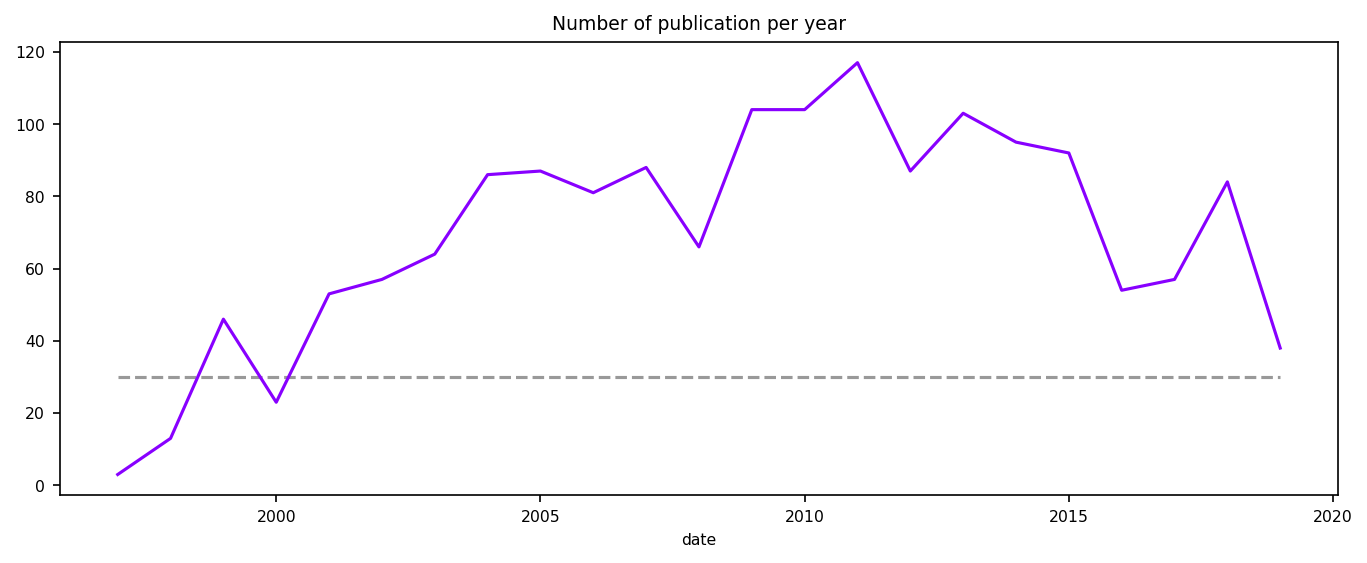

In [12]:
corpus.groupby(by='date').date.count().plot(
    title='Number of publication per year',  
    color='#8800ff'
)
plt.hlines(
    30, 
    corpus.date.min(), 
    corpus.date.max(), 
    colors='#999999', 
    linestyles='dashed'
)
pass

On peut alors remarquer que les publications sont assez bien réparties dans le temps ce qui nous donnera la possibilité de faire nos analyses avec un axe temporel en fonction de notre avancement. 
(A noter que la droite horizontale est le seuil arbitraire placer à count=30 pour lequel nous estimons qu'une analyse est possible. Selon ce seuil, nous pourrons analyser les données de toutes les publications à partir de l'année 2000)

## Nettoyage des données

Nous avons pu voir qu'aucune ligne n'est à supprimer puisque toutes nos données comportent au moins un titre ou un content ou un asbtract/keywords. 
Donc tout est utilisable à analyse. Mais il sera nécessaire et indispensable de nettoyer nos données.

Pour les exemples qui vont suivres, nous allons utiliser les 5 premières lignes de abstract_fr en tant que visualisation de notre nettoyage car ces sont des paragraphes courts contrairement aux contenus et ne contiennent pas seulement une phrase contrairement aux titres.

In [13]:
pd.set_option('max_colwidth', 400)  # default = 50

corpus_sample = corpus.iloc[:5][["abstract_fr", "lang"]]
corpus_sample

abstract_fr lang
0  \nNous considérons dans notre travail la tâche du traitement automatique visant à construire, à partir de textes issus d'un corpus de constats d'accidents de la route, des interprétations compatibles avec ces derniers, et à en proposer des illustrations sous forme de séquences d'images fixes. Notre recherche est le fruit d'une collaboration entre un laboratoire universitaire et une entreprise....   fr
1                                                                                                                                                                                                                            \nNous donnons ici un aperçu du logiciel DECID développé au GETA afin d'informatiser le processus de rédaction du dictionnaire explicatif et combinatoire du français contemporain.\n   fr
2  \nDiverses méthodes ont été proposées pour construire un "graphe conceptuel" représentant le "sens" d'une phrase à partir de son analyse syntaxique. Cependant, peu d'entre elles reposent sur un véritable formalisme linguistique. Nous nous intéressons ici à la construction d'une telle représentation sémantique à partir de la représentation syntaxique produite par une analyse LFG, et montrons co...   fr
3                                                           \nLe terme de lambda-DRT désigne un ensemble de méthodes permettant de construire des représentations sémantiques (DRS) à partir d'arbres syntaxiques. La mise en oeuvre de telles méthodes nécessite l'élaboration de systèmes de types dont le détail est rarement présenté. C'est à la description d'un tel système que cet article est consacré.\n   fr
4  \nDans cet article, nous comparons deux modèles linguistiques utilisés en TAL, les grammaires d'arbres adjoints [= TAG] et le Théorie Sens-Texte [= TST]. Nous montrons que ces deux modèles présentent des similitudes notables, et que les représentations les plus abstraites qu'ils donnent d'une phrase — la représentation sémantique en TST et l'arbre de dérivation en TAG — sont équivalentes. De c...   fr

### Suppression des accents

La première étape est plutot simple. On enlève les accents en passant simplement pas la case ascii.



In [14]:
def remove_accent(text):
    norm = ucd.normalize('NFKD', text)
    ascii = norm.encode('ascii', 'ignore')
    text = ascii.decode('utf-8', 'ignore')
    return text

corpus_sample["abstract_fr"] = corpus_sample.apply(
    lambda x: remove_accent(x["abstract_fr"]), 
    axis=1
)
corpus_sample


abstract_fr lang
0  \nNous considerons dans notre travail la tache du traitement automatique visant a construire, a partir de textes issus d'un corpus de constats d'accidents de la route, des interpretations compatibles avec ces derniers, et a en proposer des illustrations sous forme de sequences d'images fixes. Notre recherche est le fruit d'une collaboration entre un laboratoire universitaire et une entreprise....   fr
1                                                                                                                                                                                                                            \nNous donnons ici un apercu du logiciel DECID developpe au GETA afin d'informatiser le processus de redaction du dictionnaire explicatif et combinatoire du francais contemporain.\n   fr
2  \nDiverses methodes ont ete proposees pour construire un "graphe conceptuel" representant le "sens" d'une phrase a partir de son analyse syntaxique. Cependant, peu d'entre elles reposent sur un veritable formalisme linguistique. Nous nous interessons ici a la construction d'une telle representation semantique a partir de la representation syntaxique produite par une analyse LFG, et montrons co...   fr
3                                                           \nLe terme de lambda-DRT designe un ensemble de methodes permettant de construire des representations semantiques (DRS) a partir d'arbres syntaxiques. La mise en oeuvre de telles methodes necessite l'elaboration de systemes de types dont le detail est rarement presente. C'est a la description d'un tel systeme que cet article est consacre.\n   fr
4  \nDans cet article, nous comparons deux modeles linguistiques utilises en TAL, les grammaires d'arbres adjoints [= TAG] et le Theorie Sens-Texte [= TST]. Nous montrons que ces deux modeles presentent des similitudes notables, et que les representations les plus abstraites qu'ils donnent d'une phrase  la representation semantique en TST et l'arbre de derivation en TAG  sont equivalentes. De ce ...   fr

### Passage en minuscule

On met tout en minuscule puisque "n" est différent de "N" ce qui n'a pas trop de sens considérant un mot (sauf nom propres que l'on considèreras comme non essentiel)

A noter que ce choix délibéré de ne pas compter les noms propre semble pertinent mais dans le cas de papier de recherche, les noms propres peuvent avoir leur importance plus que dans un texte quelconque.

In [15]:
def set_lower(text):
    return text.lower()

corpus_sample["abstract_fr"] = corpus_sample.apply(
    lambda x: set_lower(x["abstract_fr"]), 
    axis=1
)
corpus_sample

abstract_fr lang
0  \nnous considerons dans notre travail la tache du traitement automatique visant a construire, a partir de textes issus d'un corpus de constats d'accidents de la route, des interpretations compatibles avec ces derniers, et a en proposer des illustrations sous forme de sequences d'images fixes. notre recherche est le fruit d'une collaboration entre un laboratoire universitaire et une entreprise....   fr
1                                                                                                                                                                                                                            \nnous donnons ici un apercu du logiciel decid developpe au geta afin d'informatiser le processus de redaction du dictionnaire explicatif et combinatoire du francais contemporain.\n   fr
2  \ndiverses methodes ont ete proposees pour construire un "graphe conceptuel" representant le "sens" d'une phrase a partir de son analyse syntaxique. cependant, peu d'entre elles reposent sur un veritable formalisme linguistique. nous nous interessons ici a la construction d'une telle representation semantique a partir de la representation syntaxique produite par une analyse lfg, et montrons co...   fr
3                                                           \nle terme de lambda-drt designe un ensemble de methodes permettant de construire des representations semantiques (drs) a partir d'arbres syntaxiques. la mise en oeuvre de telles methodes necessite l'elaboration de systemes de types dont le detail est rarement presente. c'est a la description d'un tel systeme que cet article est consacre.\n   fr
4  \ndans cet article, nous comparons deux modeles linguistiques utilises en tal, les grammaires d'arbres adjoints [= tag] et le theorie sens-texte [= tst]. nous montrons que ces deux modeles presentent des similitudes notables, et que les representations les plus abstraites qu'ils donnent d'une phrase  la representation semantique en tst et l'arbre de derivation en tag  sont equivalentes. de ce ...   fr

### Replacements avec Expressions Régulières

Nous arrivons à la dernière étape de nettoyage de nos données et celle-ci est plus complexe. Nous utiliserons les expressions régulières pour traiter d'un coup unique plusieurs nettoyages. 


In [16]:
replacement_patterns = [
     # remove extra lines
     (r'\n', ''),
     # remove special characters
     (r'[^a-zA-Z\d\s]', ' '),
     # remove extra space
     (r'\s{2,}', ' '),
]

replacement_patterns_en = [
     # gestion de quelques contractions
     (r'n\'', 'ne '),
     (r'can\'t', 'cannot'),
     (r'i\'m', 'i am'),
     (r'ain\'t', 'is not'),
     (r'(\w+)\'ll', r'\g<1> will'),
     (r'(\w+)n\'t', r'\g<1> not'),
     (r'(\w+)\'ve', r'\g<1> have'),
     (r'(\w+)\'s', r'\g<1> is'),
     (r'(\w+)\'re', r'\g<1> are'),
     (r'(\w+)\'d', r'\g<1> would'),
] + replacement_patterns 

replacement_patterns_fr = [
     # remplacement des contractions avec seulement un "e" a la fin
     # exemple : "qu'ils" devient "que ils"
     (r'(\w+)\'', r'\g<1>e '),
] + replacement_patterns



class RegexpReplacer(object):

    def __init__(self):
        self.patterns = {
            'en': [(re.compile(regex), repl) for (regex, repl) in replacement_patterns_en],
            'fr': [(re.compile(regex), repl) for (regex, repl) in replacement_patterns_fr]
        }

    def __call__(self, text, lang):
        s = text
        for (pattern, repl) in self.patterns[lang]:
            s = re.sub(pattern, repl, s)
        return s

replace_regex = RegexpReplacer()


corpus_sample["abstract_fr"] = corpus_sample.apply(
    lambda x: replace_regex(x["abstract_fr"], "fr"), 
    axis=1
)
corpus_sample

abstract_fr lang
0  nous considerons dans notre travail la tache du traitement automatique visant a construire a partir de textes issus de un corpus de constats de accidents de la route des interpretations compatibles avec ces derniers et a en proposer des illustrations sous forme de sequences de images fixes notre recherche est le fruit de une collaboration entre un laboratoire universitaire et une entreprise el...   fr
1                                                                                                                                                                                                                               nous donnons ici un apercu du logiciel decid developpe au geta afin de informatiser le processus de redaction du dictionnaire explicatif et combinatoire du francais contemporain    fr
2  diverses methodes ont ete proposees pour construire un graphe conceptuel representant le sens de une phrase a partir de son analyse syntaxique cependant peu de entre elles reposent sur un veritable formalisme linguistique nous nous interessons ici a la construction de une telle representation semantique a partir de la representation syntaxique produite par une analyse lfg et montrons comment u...   fr
3                                                               le terme de lambda drt designe un ensemble de methodes permettant de construire des representations semantiques drs a partir de arbres syntaxiques la mise en oeuvre de telles methodes necessite le elaboration de systemes de types dont le detail est rarement presente ce est a la description de un tel systeme que cet article est consacre    fr
4  dans cet article nous comparons deux modeles linguistiques utilises en tal les grammaires de arbres adjoints tag et le theorie sens texte tst nous montrons que ces deux modeles presentent des similitudes notables et que les representations les plus abstraites que ils donnent de une phrase la representation semantique en tst et le arbre de derivation en tag sont equivalentes de ce rapprochement...   fr

### Suppression des Stopwords

On va supprimer aussi les stopwords. Il faut aussi, comme dans les cas des regex, utiliser un set de stopwords qui sera propre à la langue dans laquelle est le texte. En l'occurence on télécharger les stopwrods de la langue anglaise et de la langue francaise

In [17]:
class StopWordsRemover(object):

    def __init__(self, regex_split=r'[a-zA-Z]+'):
        self.stopwords = {
            'en': set(stopwords.words('english')),
            'fr': set(stopwords.words('french'))
        }
        self.tokenizer = RegexpTokenizer(regex_split)

    def __call__(self, text, lang):
        text = self.tokenizer.tokenize(text)
        text = ' '.join([x for x in text if not x in self.stopwords[lang]])
        return text

remove_stopwords = StopWordsRemover()

corpus_sample["abstract_fr"] = corpus_sample.apply(
    lambda x: remove_stopwords(x["abstract_fr"], "fr"), 
    axis=1
)
corpus_sample

abstract_fr lang
0  considerons travail tache traitement automatique visant a construire a partir textes issus corpus constats accidents route interpretations compatibles derniers a proposer illustrations sous forme sequences images fixes recherche fruit collaboration entre laboratoire universitaire entreprise prend appui modele grammaire applicative cognitive vise particulier a expliquer a certain niveau cogniti...   fr
1                                                                                                                                                                                                                                                                donnons ici apercu logiciel decid developpe geta afin informatiser processus redaction dictionnaire explicatif combinatoire francais contemporain   fr
2  diverses methodes ete proposees construire graphe conceptuel representant sens phrase a partir analyse syntaxique cependant peu entre elles reposent veritable formalisme linguistique interessons ici a construction telle representation semantique a partir representation syntaxique produite analyse lfg montrons comment transposition joint dirige graphes conceptuels permet effectuer cette constru...   fr
3                                                                                                                                       terme lambda drt designe ensemble methodes permettant construire representations semantiques drs a partir arbres syntaxiques mise oeuvre telles methodes necessite elaboration systemes types dont detail rarement presente a description tel systeme cet article consacre   fr
4  cet article comparons deux modeles linguistiques utilises tal grammaires arbres adjoints tag theorie sens texte tst montrons deux modeles presentent similitudes notables representations plus abstraites donnent phrase representation semantique tst arbre derivation tag equivalentes rapprochement decoule part peut inspirer procedure derivation tag operer correspondance sens texte autre part peut ...   fr

### Lemmatization

Enfin notre dernière fonction permet de lemmatizer un texte. Encore une fois, il nous faut une possibilité francaise et une autre anglaise

In [18]:
class Lemmatizer(object):

    def __init__(self, regex_split=r'[a-zA-Z]+'):
        self.lemmatizer = {
            'en': spacy.load('en'),
            'fr': spacy.load('fr')
        }
        self.tokenizer = RegexpTokenizer(regex_split)

    def __call__(self, text, lang):
        text = ' '.join([x.lemma_ for x in self.lemmatizer[lang](text)])
        return text

lemmatize = Lemmatizer()


corpus_sample["abstract_fr"] = corpus_sample.apply(
    lambda x: lemmatize(x["abstract_fr"], "fr"), 
    axis=1
)
corpus_sample

abstract_fr lang
0  consideron travail tach traitement automatique viser avoir construir avoir partir texte issu corpus constat accident route interpretation compatible dernier avoir proposer illustration sous forme sequence image fixe recherche fruit collaboration entre laboratoire universitaire entreprise prendre appui modele grammair applicatif cognitif vis particulier avoir expliquer avoir certain niveau cogn...   fr
1                                                                                                                                                                                                                                                                   donnon ici apercu logiciel decid developpe geta afin informatiser processus redaction dictionnair explicatif combinatoire francai contemporain   fr
2  divers methode ete proposee construir graphe conceptuel representer sen phrase avoir partir analyse syntaxique cependant peu entre lui reposer veritabl formalisme linguistique interesson ici avoir construction tel representation semantiqu avoir partir representation syntaxique produire analyse lfg montron comment transposition joint diriger graphes conceptuel permettre effectuer ce constructio...   fr
3                                                                                                                                               terme lambder drt designe ensembl methode permettre construir representation semantique dr avoir partir arbre syntaxique mise oeuvre tel methode necessite elaboration systemes type dont detail raremer presente avoir description tel systeme ce article consacr   fr
4  ce article comparon deux modele linguistique utilise tal grammaire arbre adjoint tag theorie sen texte tst montron deux modele presenter similitude notable representation plus abstrait donner phrase representation semantiqu tst arbre derivation tag equivalente rapprochemer decoul part pouvoir inspirer procedure derivation tag operer correspondance sen texte autre part pouvoir concevoir grammai...   fr

En regardant de plus près notre lemmatization, au jugé, nous trouvons qu'elle n'est pas superbe. Elle altère mal le texte francais car trop peu d'équivalents sont trouvés dans ce vocabulaire trop technique et peu courant qu'est celui de papier de recherche. Alors nous décidons finalement de ne pas utiliser de lemmatization au risque de nuire à nos données plus qu'autre chose

### N-Gram 

Enfin, nous aurons besoin de "Tokeniser" nos phrases après nettoyage. 
Nous faisons cette fonction à part pour deux raisons :
- nous ne sommes pas obligés de tokenizer pour tous les algorithmes
- nous pourrons tester des unigram, bigram, trigram... 


In [19]:
regex_split = r'[a-zA-Z]+'
tokenizer = RegexpTokenizer(regex_split)

def n_gram_tokenize(text, n, n_gram_jointure=None):
    # tokenization
    text_tokenized = tokenizer.tokenize(text)
    # n-gram 
    text_tokenized = [text_tokenized[i:i+n] for i in range(len(text_tokenized)- n + 1)]
    # jointure if asked
    if n_gram_jointure is not None:
        text_tokenized = [n_gram_jointure.join(x) for x in text_tokenized]
    return text_tokenized

corpus_sample["abstract_fr"] = corpus_sample.apply(
    lambda x: n_gram_tokenize(x["abstract_fr"], 2, n_gram_jointure=' '), 
    axis=1
)
corpus_sample

abstract_fr lang
0  [consideron travail, travail tach, tach traitement, traitement automatique, automatique viser, viser avoir, avoir construir, construir avoir, avoir partir, partir texte, texte issu, issu corpus, corpus constat, constat accident, accident route, route interpretation, interpretation compatible, compatible dernier, dernier avoir, avoir proposer, proposer illustration, illustration sous, sous form...   fr
1                                                                                                                        [donnon ici, ici apercu, apercu logiciel, logiciel decid, decid developpe, developpe geta, geta afin, afin informatiser, informatiser processus, processus redaction, redaction dictionnair, dictionnair explicatif, explicatif combinatoire, combinatoire francai, francai contemporain]   fr
2  [divers methode, methode ete, ete proposee, proposee construir, construir graphe, graphe conceptuel, conceptuel representer, representer sen, sen phrase, phrase avoir, avoir partir, partir analyse, analyse syntaxique, syntaxique cependant, cependant peu, peu entre, entre lui, lui reposer, reposer veritabl, veritabl formalisme, formalisme linguistique, linguistique interesson, interesson ici, i...   fr
3  [terme lambder, lambder drt, drt designe, designe ensembl, ensembl methode, methode permettre, permettre construir, construir representation, representation semantique, semantique dr, dr avoir, avoir partir, partir arbre, arbre syntaxique, syntaxique mise, mise oeuvre, oeuvre tel, tel methode, methode necessite, necessite elaboration, elaboration systemes, systemes type, type dont, dont detail...   fr
4  [ce article, article comparon, comparon deux, deux modele, modele linguistique, linguistique utilise, utilise tal, tal grammaire, grammaire arbre, arbre adjoint, adjoint tag, tag theorie, theorie sen, sen texte, texte tst, tst montron, montron deux, deux modele, modele presenter, presenter similitude, similitude notable, notable representation, representation plus, plus abstrait, abstrait donn...   fr

### Tout en un

Il ne reste plus qu'à  regrouper nos fonctions pour les appliquer par colonne facilement

In [20]:
def clean_column(df, col, lang, lang_is_col=False, n_gram=None, n_gram_jointure=None, inplace=False):
    if not inplace:
        df = df.copy()

    # avoid exceptions of None values replacing them with "None" values
    df[col] = df.apply(
        lambda x:x[col] if x[col] is not None else 'None',
        axis=1
    )

    # remove accents
    df[col] = df.apply(
        lambda x:remove_accent(x[col]),
        axis=1
    )
    # to lower
    df[col] = df.apply(
        lambda x:set_lower(x[col]),
        axis=1
    )
    # replace regex
    df[col] = df.apply(
        lambda x:replace_regex(x[col], x[lang] if lang_is_col else lang),
        axis=1
    )
    # remove stopwords
    df[col] = df.apply(
        lambda x:remove_stopwords(x[col], x[lang] if lang_is_col else lang),
        axis=1
    )
    # n gram
    if n_gram is not None:
        df[col] = df.apply(
            lambda x:n_gram_tokenize(x[col], n_gram, n_gram_jointure),
            axis=1
        )
    return df

### Nettoyage complet du corpus sans tokenization

Avant de faire toutes nos analyses, on aura besoin donc de notre corpus entièrement nettoyé. Mais nous gardons ce copurs sans tokenization pour en essayer des différentes. 


In [21]:
pd.set_option('max_colwidth', 50)  # default = 50
clean_column(corpus, 'title', 'lang', lang_is_col=True, n_gram=None, inplace=True)
clean_column(corpus, 'content', 'lang', lang_is_col=True, n_gram=None, inplace=True)
clean_column(corpus, 'abstract_fr', 'fr', n_gram=None, inplace=True)
clean_column(corpus, 'abstract_en', 'en', n_gram=None, inplace=True)
clean_column(corpus, 'keywords_fr', 'fr', n_gram=None, inplace=True)
clean_column(corpus, 'keywords_en', 'en', n_gram=None, inplace=True)
corpus

title  ...                                            content
0     elements conception systeme interpretation aut...  ...  modele grammaire applicative cognitive ga post...
1     informatisation dictionnaire explicatif combin...  ...  domaine ingenierie linguistique connaissance p...
2     construction representation semantique graphes...  ...                                                   
3                  systemes types lambda drt ascendante  ...  theorie representations discursives drt introd...
4     grammaire tag vue comme grammaire sens texte p...  ...  tag formalisme initialement developpe cadre th...
...                                                 ...  ...                                                ...
1597  curriculum apprentissage reconnaissance entite...  ...  apprentissage humain realise etapes successive...
1598      detection ellipses corpus sous titres anglais  ...  ellipse renvoie a incompletude syntaxique phra...
1599             generation automatique poesie francais  ...  generation automatique poesie tache ardue syst...
1600  modeles neuronaux hybrides modelisation sequen...  ...  etiquetage sequences probleme important tal no...
1601  polylexfle base donnees expressions polylexica...  ...  expressions polylexicales ep constituent class...

[1602 rows x 10 columns]

### Unigram et Bigram dataset

Nous pouvons alors à l'aide de notre corpus nettoyé, concevoir nos token. Pour cette étude nous avons décidé de ne traiter que des unigram et de bigram. Nous aurions pu aller plus loin dans les ngram mais plus le ngram est important et plus la complexité l'est aussi. Nous avons un tout petit dataset donc il se peut même que les bigram soient de trop. 
Nous verrons cela par la suite.

In [22]:
unigram_corpus = corpus.copy()
bigram_corpus = corpus.copy()
cols = ['title', 'abstract_fr', 'abstract_en', 'keywords_fr', 'keywords_en', 'content']

for col in cols:
    unigram_corpus[col] = unigram_corpus.apply(lambda x:n_gram_tokenize(x[col], 1, ' '), axis=1)
    bigram_corpus[col]  =  bigram_corpus.apply(lambda x:n_gram_tokenize(x[col], 2, ' '), axis=1) 

In [23]:
unigram_corpus

title  ...                                            content
0     [elements, conception, systeme, interpretation...  ...  [modele, grammaire, applicative, cognitive, ga...
1     [informatisation, dictionnaire, explicatif, co...  ...  [domaine, ingenierie, linguistique, connaissan...
2     [construction, representation, semantique, gra...  ...                                                 []
3            [systemes, types, lambda, drt, ascendante]  ...  [theorie, representations, discursives, drt, i...
4     [grammaire, tag, vue, comme, grammaire, sens, ...  ...  [tag, formalisme, initialement, developpe, cad...
...                                                 ...  ...                                                ...
1597  [curriculum, apprentissage, reconnaissance, en...  ...  [apprentissage, humain, realise, etapes, succe...
1598  [detection, ellipses, corpus, sous, titres, an...  ...  [ellipse, renvoie, a, incompletude, syntaxique...
1599        [generation, automatique, poesie, francais]  ...  [generation, automatique, poesie, tache, ardue...
1600  [modeles, neuronaux, hybrides, modelisation, s...  ...  [etiquetage, sequences, probleme, important, t...
1601  [polylexfle, base, donnees, expressions, polyl...  ...  [expressions, polylexicales, ep, constituent, ...

[1602 rows x 10 columns]

In [24]:
bigram_corpus

title  ...                                            content
0     [elements conception, conception systeme, syst...  ...  [modele grammaire, grammaire applicative, appl...
1     [informatisation dictionnaire, dictionnaire ex...  ...  [domaine ingenierie, ingenierie linguistique, ...
2     [construction representation, representation s...  ...                                                 []
3     [systemes types, types lambda, lambda drt, drt...  ...  [theorie representations, representations disc...
4     [grammaire tag, tag vue, vue comme, comme gram...  ...  [tag formalisme, formalisme initialement, init...
...                                                 ...  ...                                                ...
1597  [curriculum apprentissage, apprentissage recon...  ...  [apprentissage humain, humain realise, realise...
1598  [detection ellipses, ellipses corpus, corpus s...  ...  [ellipse renvoie, renvoie a, a incompletude, i...
1599  [generation automatique, automatique poesie, p...  ...  [generation automatique, automatique poesie, p...
1600  [modeles neuronaux, neuronaux hybrides, hybrid...  ...  [etiquetage sequences, sequences probleme, pro...
1601  [polylexfle base, base donnees, donnees expres...  ...  [expressions polylexicales, polylexicales ep, ...

[1602 rows x 10 columns]

## Loi de Zipf

La loi de Zipf est une observation empirique concernant la fréquence des mots dans un texte. La loi de Zipf dit que le nombre d'occurence d'un mot dans un corpus est inversement proportionnel à son rang. C'est une analyse intéressante selon nous. On voulait savoir si notre corpus de publication respecte cette distribution. 


### Création de la méthode

On se créer d'abord une méthode qui nous permet de nous retourner pour une colonne d'un dataframe donné, la liste des mots ordonnés par fréquence d'apparition et la liste de fréquence associée.

In [25]:
from nltk.probability import FreqDist

def zipf(df, col, df_mask=None, to_freq=False):
    if df_mask is not None:
        df = df[df_mask]
    # get the number of occurences of each words
    words = [word for value in df[col].values for word in value]
    fdist = FreqDist(words)
    # sort these words according to their occurence
    sorted_words = sorted(fdist, key=fdist.get, reverse=True)
    # get the frequence of these words
    sorted_occurences = np.array([fdist[word] for word in sorted_words])
    if to_freq:
        sorted_occurences = sorted_occurences / np.sum(sorted_occurences)
    return sorted_words, sorted_occurences

### Zipfs sur les Unigram

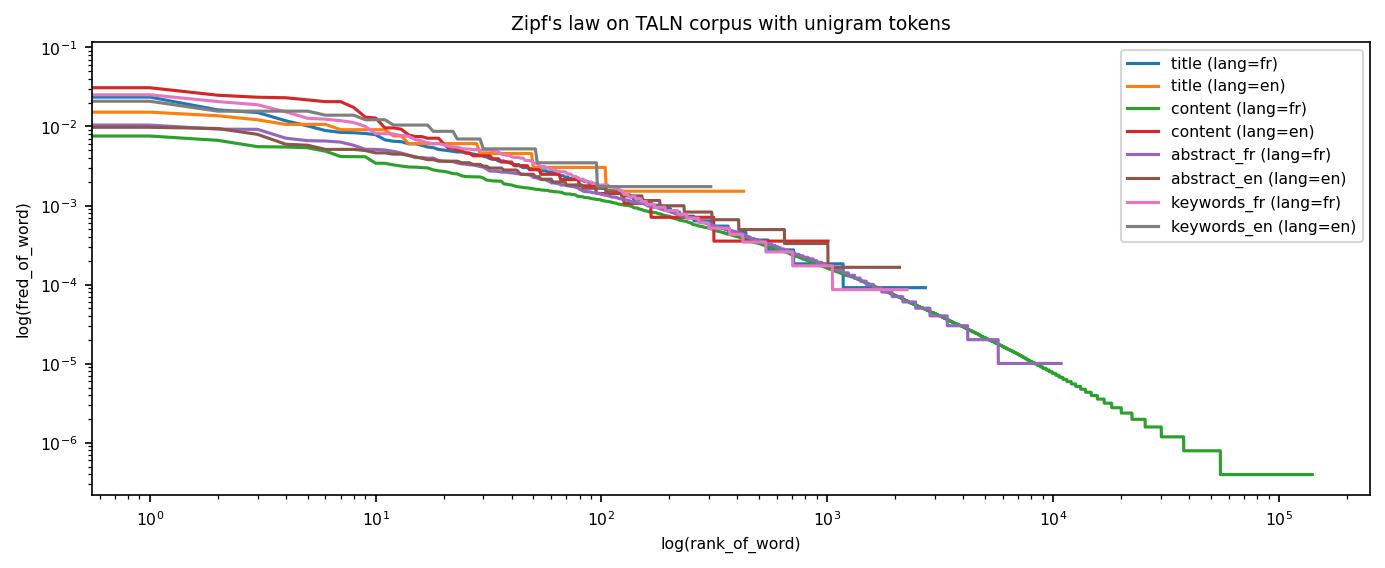

In [26]:
cols = ['title', 'title', 'content', 'content', 'abstract_fr', 'abstract_en', 'keywords_fr', 'keywords_en']
lang_filters = ['fr', 'en', 'fr', 'en', 'fr', 'en', 'fr', 'en']

for col, lang in zip(cols, lang_filters):
    # mask on langage
    mask = unigram_corpus.lang == lang 
    # get the words and frequencies in this columns for this langagz
    words, freqs = zipf(unigram_corpus, col, mask, to_freq=True)
    # plot it
    plt.plot(range(freqs.shape[0]), freqs, label=f'{col} (lang={lang})')

# add log scales to better visualize the Zip's law if exists
plt.xscale('log')
plt.yscale('log')
# Add title and axis names and legends
plt.title('Zipf\'s law on TALN corpus with unigram tokens')
plt.xlabel('log(rank_of_word)')
plt.ylabel('log(fred_of_word)')
plt.legend()
pass

### Zipfs sur les Bigram

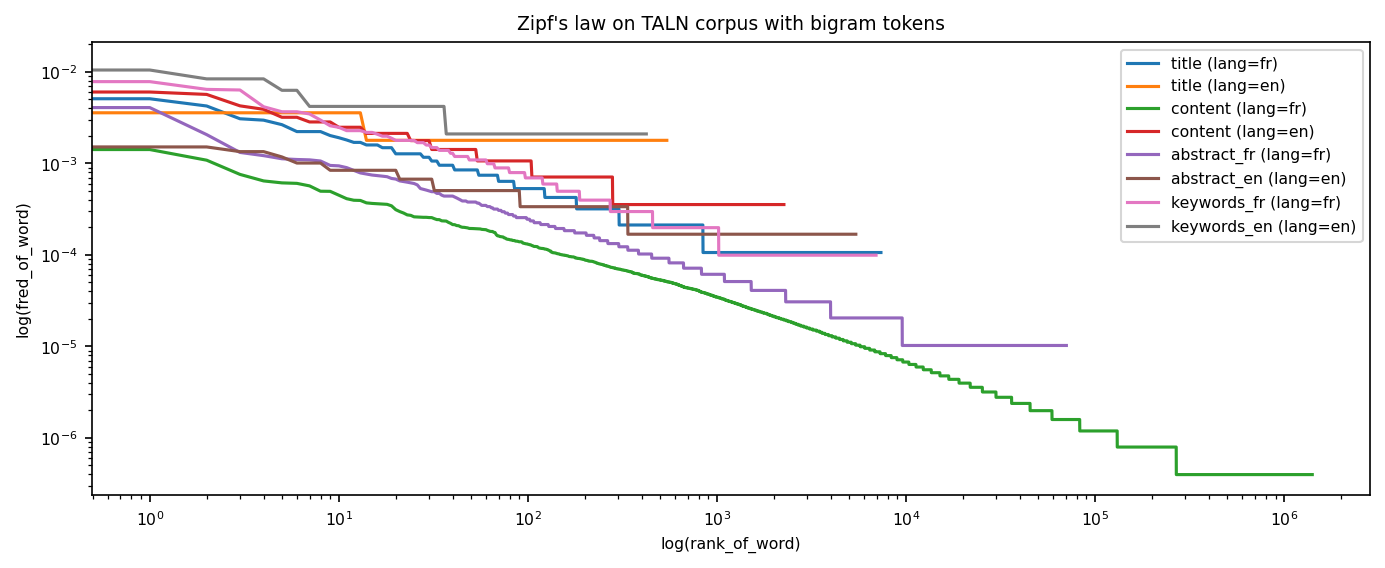

In [27]:
cols = ['title', 'title', 'content', 'content', 'abstract_fr', 'abstract_en', 'keywords_fr', 'keywords_en']
lang_filters = ['fr', 'en', 'fr', 'en', 'fr', 'en', 'fr', 'en']

for col, lang in zip(cols, lang_filters):
    # mask on langage
    mask = bigram_corpus.lang == lang 
    # get the words and frequencies in this columns for this langagz
    words, freqs = zipf(bigram_corpus, col, mask,to_freq=True)
    # plot it
    plt.plot(range(freqs.shape[0]), freqs, label=f'{col} (lang={lang})')

# add log scales to better visualize the Zip's law if exists
plt.xscale('log')
plt.yscale('log')
# Add title and axis names and legends
plt.title('Zipf\'s law on TALN corpus with bigram tokens')
plt.xlabel('log(rank_of_word)')
plt.ylabel('log(fred_of_word)')
plt.legend()
pass

Il est très interessant de voir que en francais comme en anglais, pour le titre, l'abstract, le contenu ou les keywords, la répartition de chaque sous corpus semble suivre la loi de Zipf. 
Il semble (a l'oeil nu) qu'il y ait une forte relation proportionnelle entre le rang de chaque mot et sa fréquence, comme on peut le voir sur les deux graphs ci-dessus à echelle logarithmique. 
Par ailleurs, pas très étonnant mais cela fonctionne aussi bien sur les unigram que sur les bigram. 
On ne peut pas en tirer beaucoup d'informations intéressante avec cette loi mais au moins on sait que notre corpus, bien que technique et spécialisé dans le NLP, a une répartition de ses mots telle que la répartition des mots au sein d'une langue donnée. 


## Mots les plus récurrents

Dans cette partie, non loin de la précédente, nous allons essayer de comprendre quels sont les mots les plus récurrents de ce corpus. Nous ne traiterons que les titres, abstract et keywords car nous considérons que le contenu sera résumé par ces parties et n'apportera pas d'information supplémentaires quant à la pertinence des mots les plus récurrents.

### Francais Unigram

#### Concatenation titre, abstract, keywords

Nous allons donc nous créer une table dans laquelle nous ne garderons que les articles francais et nous y ajouterons une colonne qui concatène le titre, l'abstract et les keywords


In [28]:
pd.set_option('max_colwidth', 300)  # default = 50

unigram_corpus_fr = unigram_corpus[unigram_corpus.lang == 'fr']

# "tak" for title, abstract and keywords
cols = ['title', 'abstract_fr', 'keywords_fr']
unigram_corpus_fr['tak'] = unigram_corpus_fr[cols].apply(
    # flatten list of list x
    lambda x: [inner for outer in x for inner in outer]  
    , axis=1
)
unigram_corpus_fr[cols + ['tak']]


title  ...                                                                                                                                                                                                                                                                                                          tak
0                         [elements, conception, systeme, interpretation, automatique, textes, images]  ...  [elements, conception, systeme, interpretation, automatique, textes, images, considerons, travail, tache, traitement, automatique, visant, a, construire, a, partir, textes, issus, corpus, constats, accidents, route, interpretations, compatibles, derniers, a, proposer, illustrations, sous, forme,...
1                                            [informatisation, dictionnaire, explicatif, combinatoire]  ...                                                                            [informatisation, dictionnaire, explicatif, combinatoire, donnons, ici, apercu, logiciel, decid, developpe, geta, afin, informatiser, processus, redaction, dictionnaire, explicatif, combinatoire, francais, contemporain, none]
2            [construction, representation, semantique, graphes, conceptuels, a, partir, analyse, lfg]  ...  [construction, representation, semantique, graphes, conceptuels, a, partir, analyse, lfg, diverses, methodes, ete, proposees, construire, graphe, conceptuel, representant, sens, phrase, a, partir, analyse, syntaxique, cependant, peu, entre, elles, reposent, veritable, formalisme, linguistique, i...
3                                                           [systemes, types, lambda, drt, ascendante]  ...  [systemes, types, lambda, drt, ascendante, terme, lambda, drt, designe, ensemble, methodes, permettant, construire, representations, semantiques, drs, a, partir, arbres, syntaxiques, mise, oeuvre, telles, methodes, necessite, elaboration, systemes, types, dont, detail, rarement, presente, a, des...
4                                    [grammaire, tag, vue, comme, grammaire, sens, texte, precompilee]  ...  [grammaire, tag, vue, comme, grammaire, sens, texte, precompilee, cet, article, comparons, deux, modeles, linguistiques, utilises, tal, grammaires, arbres, adjoints, tag, theorie, sens, texte, tst, montrons, deux, modeles, presentent, similitudes, notables, representations, plus, abstraites, don...
...                                                                                                ...  ...                                                                                                                                                                                                                                                                                                          ...
1597  [curriculum, apprentissage, reconnaissance, entites, nommees, extraction, concepts, semantiques]  ...  [curriculum, apprentissage, reconnaissance, entites, nommees, extraction, concepts, semantiques, cet, article, presentons, approche, bout, bout, extraction, concepts, semantiquesde, parole, particulier, mettons, avant, apport, chaine, apprentissage, successifpilotee, strategie, curriculum, appre...
1598                                              [detection, ellipses, corpus, sous, titres, anglais]  ...  [detection, ellipses, corpus, sous, titres, anglais, cet, article, presente, methodologie, detection, ellipses, anglais, repose, patronscombinant, informations, tokens, etiquette, morphosyntaxique, lemme, lespatrons, evalues, deux, corpus, sous, titres, travaux, constituent, etape, prealable, a,...
1599                                                       [generation, automatique, poesie, francais]  ...  [generation, automatique, poesie, francais, generation, automatique, poesie, tache, ardue, systeme, informatique, unpoeme, sens, important, prendre, compte, a, fois, aspects, linguistiques, litteraires, dernieres, annees, certain, nombre, approches, fructueuses, apparues, capables, modeliserde, ...
1600   

#### Création de méthode

On se créer une petite méthode pour que ça aille plus vite ensuite.

In [29]:
def get_top(df, col, n, df_mask=None, to_freq=False):
    
    words, freqs = zipf(df, col, df_mask, to_freq)
    # avoid index out of range
    n = min(len(words), n)
    # get the top ones
    words = words[:n]
    freqs = freqs[:n]
    return words, freqs


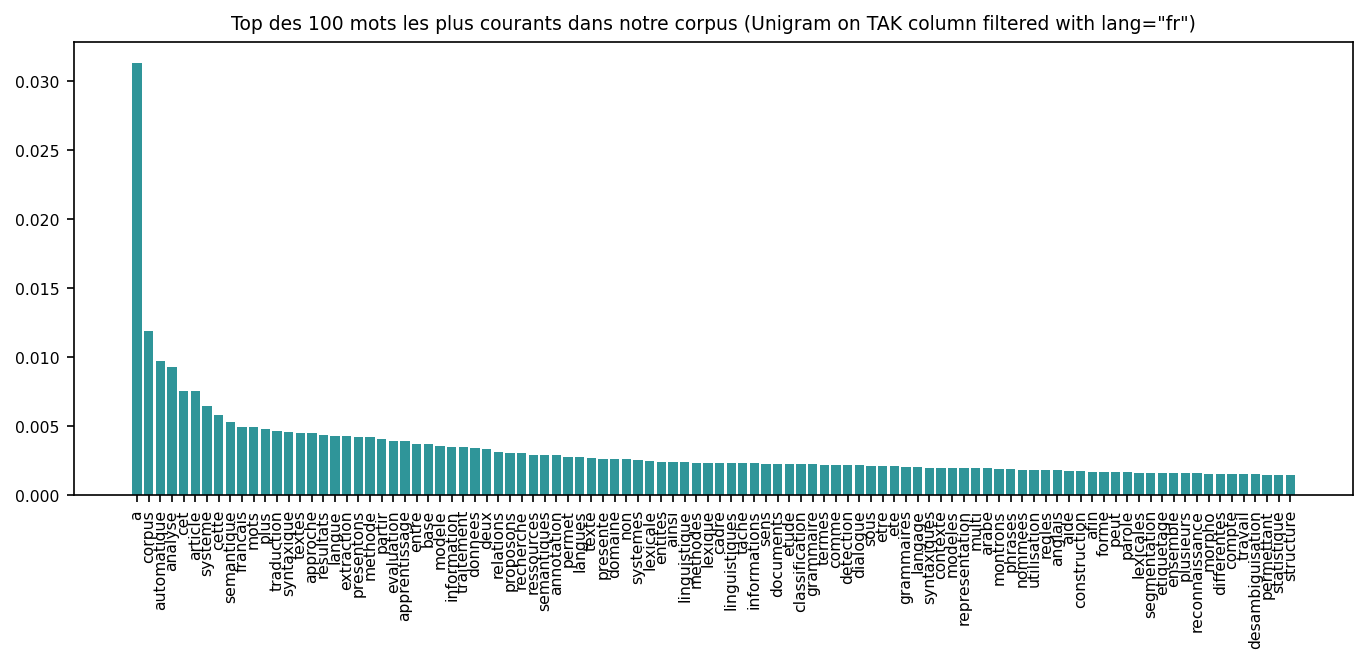

In [30]:
top_n = 100
top_words, top_freqs = get_top(unigram_corpus_fr, 'tak', top_n, to_freq=True)

plt.title(f'Top des {len(top_words)} mots les plus courants dans notre corpus (Unigram on TAK column filtered with lang="fr")')
plt.bar(range(len(top_words)), top_freqs, color='#2f9599')
plt.xticks(range(len(top_words)), top_words, rotation='vertical')
pass

On peut voir que lors de notre plot des 100 mots les plus fréquents on se retrouve avec des mots que l'on considère comme des stopwords. On note :
- a
- cet
- cette
- ...

donc nous n'allons pas les retirer mais on peut ici voir qu'ils n'apportent que peu d'information quant à notre étude et on peut alors comprendre les limites des telles approches de nettoyages de texte avec des stopwords. 
La limite est arbitraire et ce que nltk considère comme des stopwords n'est pas ce que nous considérons comme dse stopwords.

Par contre nous pouvons remarquer déjà quelque chose à l'oeil nu. C'est que le vocabulaire utilisé dans ce corpus est très technique et spécialisé. 
On remarque facilement lorsque l'on connait ces techniques qu'ils s'agit de vocabulaire issue du traitement de langage naturel (NLP).


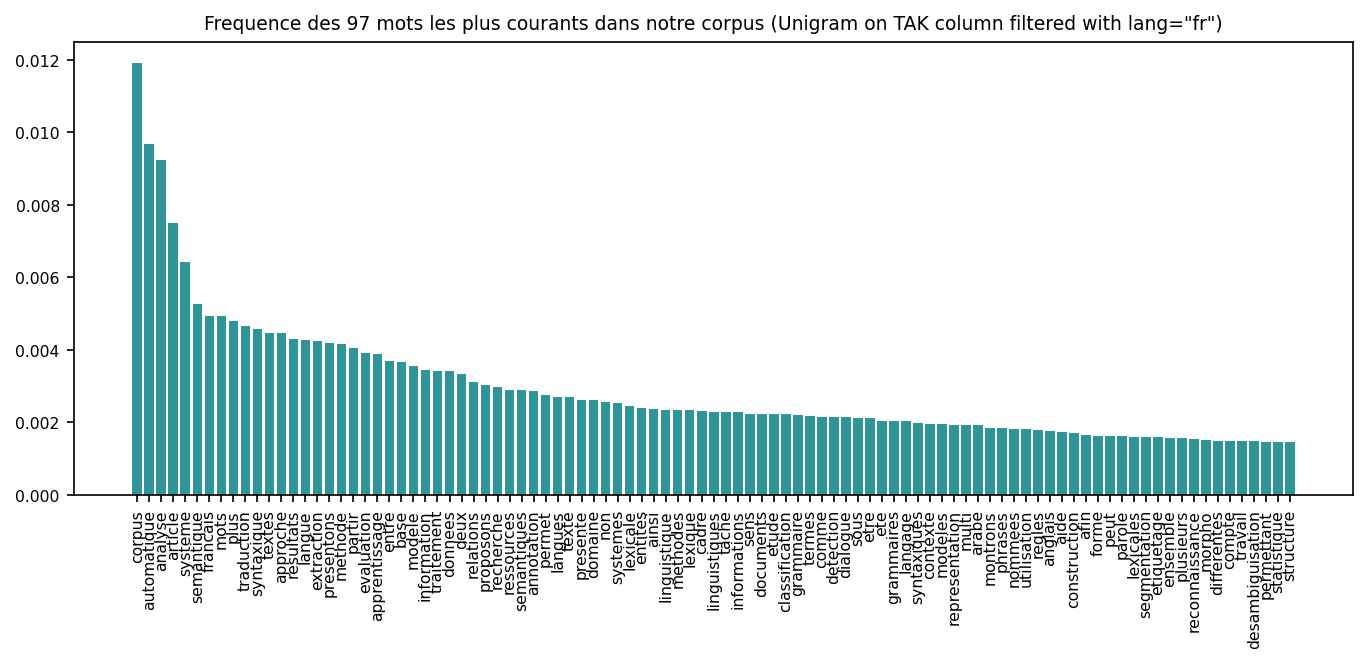

In [31]:
top_n = 100
top_words, top_freqs = get_top(unigram_corpus_fr, 'tak', top_n, to_freq=True)

# remove other custom stop_words
other_stopwords = ['a', 'cet', 'cette']
stop_idx = np.where(np.in1d(top_words, other_stopwords))
top_words = np.delete(top_words, stop_idx)
top_freqs = np.delete(top_freqs, stop_idx)

plt.title(f'Frequence des {len(top_words)} mots les plus courants dans notre corpus (Unigram on TAK column filtered with lang="fr")')
plt.bar(range(len(top_words)), top_freqs, color='#2f9599')
plt.xticks(range(len(top_words)), top_words, rotation='vertical')
pass

#### Evolution des 100 premiers mots dans le temps

Comme on l'avait dit précédemment nous avons conclu que nous pourrions analyser le corpus temporellement à partir de l'année 2000. Alors nous pensons, que dans cette logique, il est intéressant de regarder l'évolution des 100 mots les plus courant (97 sans les 3 stop words que nous avons retirés) au cours du temps.

In [32]:
# get all the years in the corpus from 2000
years = np.array([year for year in unigram_corpus_fr.date.unique() if year > 1999])

In [33]:
def get_words_freq(df, col, words_list, df_mask=None):

    if df_mask is not None:
        df = df[df_mask]
    # get the number of occurences of each words
    words = [word for value in df[col].values for word in value]
    fdist = FreqDist(words)

    # get freqs of the given words
    sum_words_count = sum(fdist.values())
    freqs = [fdist[word] / sum_words_count for word in words_list]
    return freqs 

top_freqs = get_words_freq(unigram_corpus_fr, 'tak', top_words)
for i in range(10):
    print(f'word "{top_words[i]:12}" of frequence {top_freqs[i]:.4f}')  

word "corpus      " of frequence 0.0119
word "automatique " of frequence 0.0097
word "analyse     " of frequence 0.0092
word "article     " of frequence 0.0075
word "systeme     " of frequence 0.0064
word "semantique  " of frequence 0.0053
word "francais    " of frequence 0.0049
word "mots        " of frequence 0.0049
word "plus        " of frequence 0.0048
word "traduction  " of frequence 0.0046


On retrouve bien nos valeurs que l'on voit sur notre graphique donc notre fonction est bonne et peut être utilisée avec un masque par année.

In [34]:
def plot_add_regression_line(x, y, color):
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m * x + b, '-.', color=plt.default_colors[i])

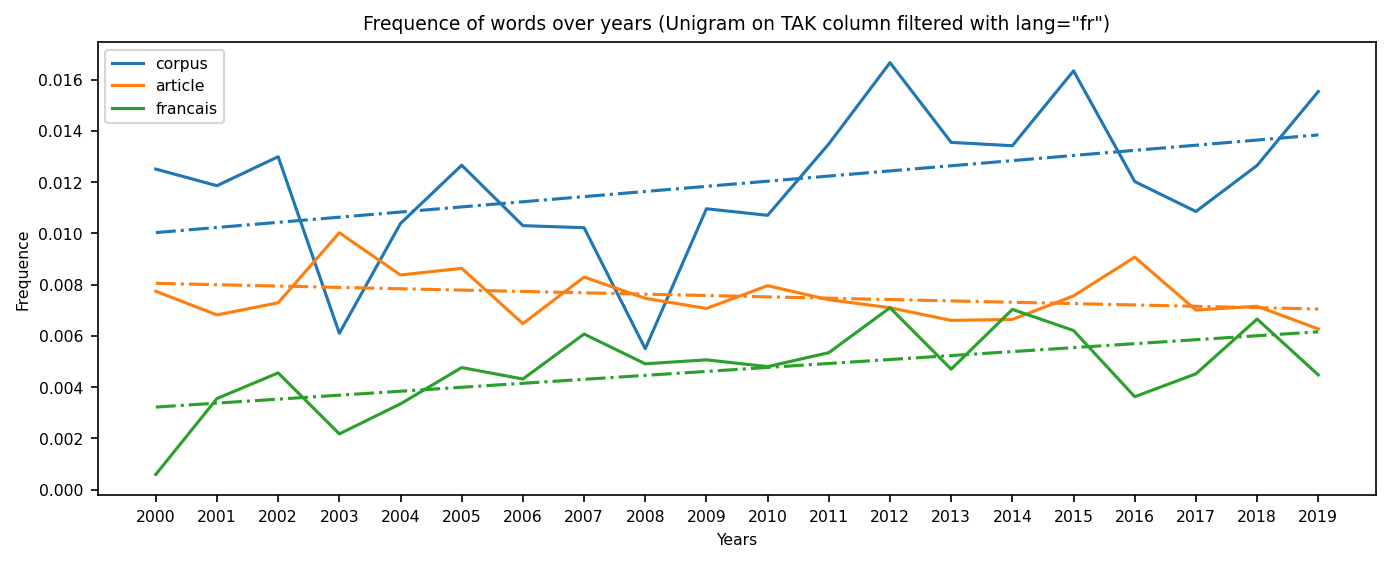

In [35]:
# Create a dict to store top words frequencies by year
top_words_all = top_words
top_freqs_all = get_words_freq(unigram_corpus_fr, 'tak', top_words)
top_freqs_by_year = {word: [] for word in top_words_all}

# iterate by year to get all the word frequencie within this year
for year in years:
    mask_year = unigram_corpus_fr.date == year
    # get the frequencies
    freqs_year = get_words_freq(unigram_corpus_fr, 'tak', top_words, df_mask=mask_year)
    for word, freq in zip(top_words_all, freqs_year):
        top_freqs_by_year[word].append(freq)

exemple_words = top_words_all[:9:3]
for i, word in enumerate(exemple_words):
    plt.plot(years, top_freqs_by_year[word], label=word, color=plt.default_colors[i])
    # add regression line
    plot_add_regression_line(years, top_freqs_by_year[word], plt.default_colors[i]) 

plt.title('Frequence of words over years (Unigram on TAK column filtered with lang="fr")')
plt.xticks(years, years)
plt.xlabel('Years')
plt.ylabel('Frequence')
plt.legend()
pass


#### Plus grandes augmentations de fréquence 
Maintenant que nous avons les evolutions de chaque mot au cours du temps nous pouvons nous concentrer sur une simple regression linéaire et estimer alors lesquels mots sont de plus en plus fréquents et inversement

In [36]:
def get_slope(x, y):
    slope, intercept = np.polyfit(x, y, deg=1)
    return slope

In [37]:
dict_slopes = {
    word: get_slope(years, top_freqs_by_year[word])
    for word in top_words_all
}

exemple_words = top_words_all[:9:3]
for word in exemple_words:
    print(f'The word "{word:8}" has a slope of {dict_slopes[word]:.5f}')
    

The word "corpus  " has a slope of 0.00020
The word "article " has a slope of -0.00005
The word "francais" has a slope of 0.00015


On peut donc savoir par exemple quels sont les 5 mots avec la meilleure évolution en terme de fréquence

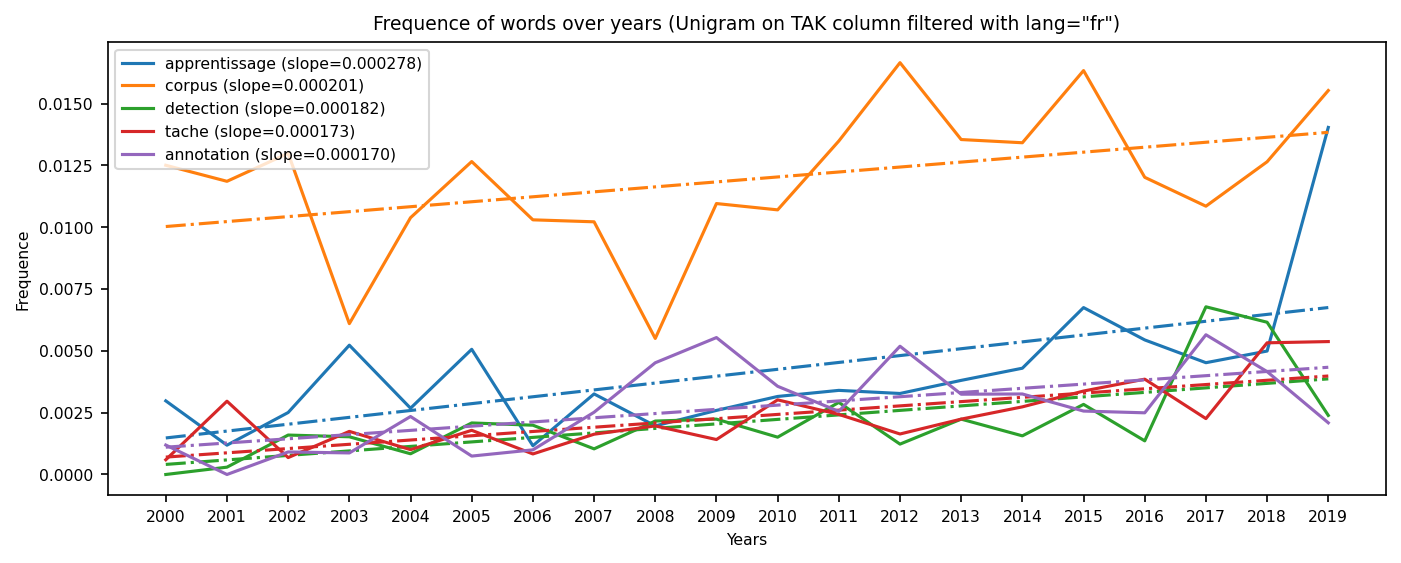

In [38]:
dict_slopes = {
    word: slope 
    for word, slope in sorted(
        dict_slopes.items(), 
        key=lambda item: item[1],
        reverse=True
    )
}
n_best = 5
for i, (word, slope) in enumerate(dict_slopes.items()):
    if not i < n_best:
        break
    plt.plot(years, top_freqs_by_year[word], label=f'{word} (slope={slope:6f})')
    # add regression line
    plot_add_regression_line(years, top_freqs_by_year[word], plt.default_colors[i]) 
plt.title('Frequence of words over years (Unigram on TAK column filtered with lang="fr")')
plt.xticks(years, years)
plt.xlabel('Years')
plt.ylabel('Frequence')
plt.legend()
pass

Le résultat n'est pas tellement surprenant mais c'est amusant de remarquer que les sujets d'actualité ressortent parfaitement sur ce graphique. 
Depuis les 10 dernières années, les enejeux majeurs en NLP sont l'apprentissage automatique, la détection de toute sorte (OCR par exemple) et le manque de donnée qui peut ressortir dans les mots "corpus" et surtout "annotation"

#### Plus grandes diminutions de fréquence

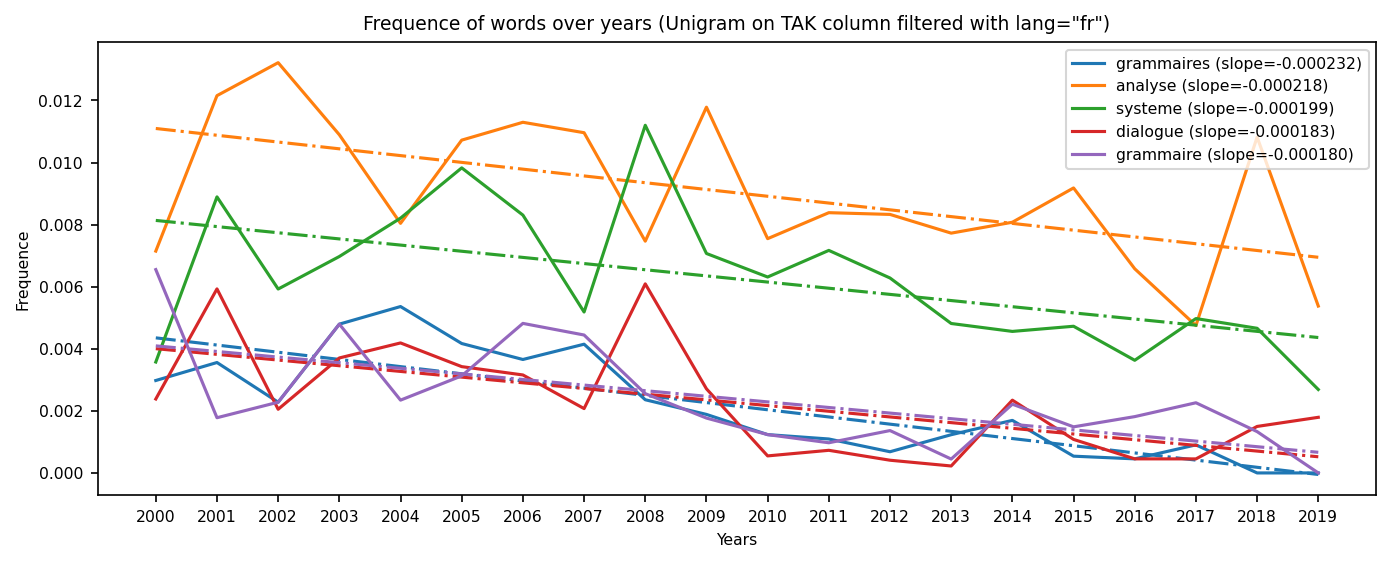

In [39]:
dict_slopes = {
    word: slope 
    for word, slope in sorted(
        dict_slopes.items(), 
        key=lambda item: item[1],
    )
}
n_best = 5
for i, (word, slope) in enumerate(dict_slopes.items()):
    if not i < n_best:
        break
    plt.plot(years, top_freqs_by_year[word], label=f'{word} (slope={slope:6f})')
    # add regression line
    plot_add_regression_line(years, top_freqs_by_year[word], plt.default_colors[i]) 
plt.title('Frequence of words over years (Unigram on TAK column filtered with lang="fr")')
plt.xticks(years, years)
plt.xlabel('Years')
plt.ylabel('Frequence')
plt.legend()
pass

A l'inverse, même s'il est difficile de déterminer pourquoi ces mots sont de moins en moins utiliser mais nous pensons sans trop nous mouiller pouvoir tous ces mots sont de moins en moins utilisés parce que l'enjeu d'apprentissage peut remplacer "l'analyse", les "systèmes", les "grammaires" en non supervisé. Par contre pour "dialogue" on peut penser que ça a été remplacé par des mots tels que "chatbot" ou "conversation" qui sont plus en vogue

### Anglais Unigram

#### Concatenation titre, abstract, keywords

(Comme pour la section Francais)


Nous allons donc nous créer une table dans laquelle nous ne garderons que les articles francais et nous y ajouterons une colonne qui concatène le titre, l'abstract et les keywords


In [40]:
pd.set_option('max_colwidth', 300)  # default = 50

unigram_corpus_en = unigram_corpus[unigram_corpus.lang == 'en']

# "tak" for title, abstract and keywords
cols = ['title', 'abstract_en', 'keywords_en']
unigram_corpus_en['tak'] = unigram_corpus_en[cols].apply(
    # flatten list of list x
    lambda x: [inner for outer in x for inner in outer]  
    , axis=1
)
unigram_corpus_en[cols + ['tak']]


title  ...                                                                                                                                                                                                                                                                                                          tak
17                                                                             [clitic, climbing, tense, auxiliaries, polish, romance]  ...  [clitic, climbing, tense, auxiliaries, polish, romance, aim, paper, compare, behaviour, polish, romance, pronominal, clitics, tense, auxiliary, constructions, account, polish, facts, first, present, system, polish, auxiliaries, briefly, comparing, romance, discuss, clitic, climbing, cc, phenomen...
20                                                                                                     [lexicalizing, shallow, parser]  ...  [lexicalizing, shallow, parser, current, nl, parsers, expected, run, throughput, rate, suitable, satisfy, time, constraints, real, applications, aim, present, work, one, hand, investigate, effects, lexical, information, shallow, parsing, environment, hand, study, limits, bootstrapping, architect...
26                 [achievements, vs, accomplishments, computational, treatment, atomicity, incrementality, perhaps, event, structure]  ...  [achievements, vs, accomplishments, computational, treatment, atomicity, incrementality, perhaps, event, structure, achievements, accomplishments, argued, paper, differ, w, r, atomicity, rather, punctuality, notion, strongly, exclusively, related, incrementality, e, eventobject, mapping, functio...
27                                                                                             [lattice, parsing, speech, recognition]  ...  [lattice, parsing, speech, recognition, lot, work, remains, done, domain, better, integration, speech, recognition, language, pro, cessing, systems, paper, gives, overview, several, strategies, integrating, linguistic, models, speech, understanding, systems, investigates, several, ways, producin...
43                                                            [robust, partial, parsing, strategy, based, slot, unification, grammars]  ...  [robust, partial, parsing, strategy, based, slot, unification, grammars, paper, present, robust, partial, parser, slot, unification, partial, parser, supp, based, slot, unification, grammars, sug, parsing, strategy, analyzes, coordinated, nouns, prepositional, phrases, verbal, chunks, verbs, sim...
...                                                                                                                                ...  ...                                                                                                                                                                                                                                                                                                          ...
1501                                                                                         [prototype, dependency, treebank, breton]  ...                                                                                                                                                                                                                                                        [prototype, dependency, treebank, breton, none, none]
1513                                                               [predicting, semantic, textual, similaritywith, siamese, cnn, lstm]  ...                                                                                                                                                                                                                              [predicting, semantic, textual, similaritywith, siamese, cnn, lstm, none, none]
1522                                                                     [detecting, context, dependent, sentences, parallel, corpora]  ...                     

#### Top 100 mots anglais


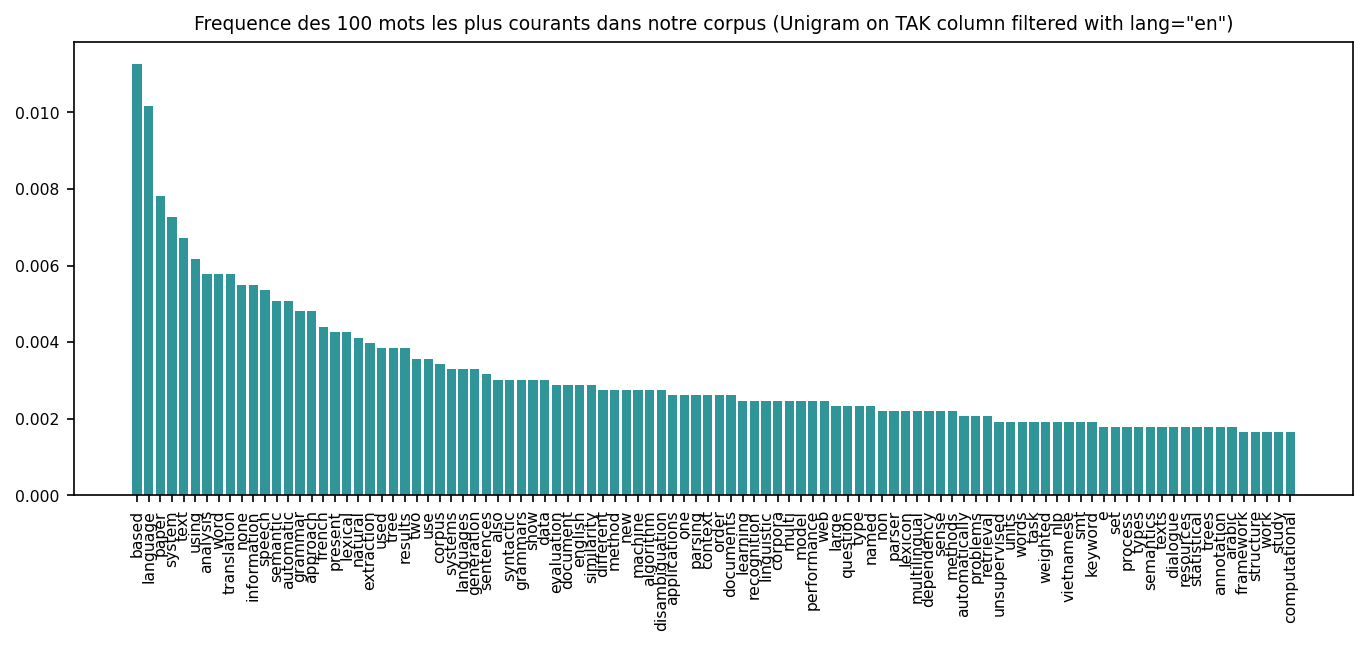

In [41]:
top_n = 100
top_words, top_freqs = get_top(unigram_corpus_en, 'tak', top_n, to_freq=True)

plt.title(f'Frequence des {len(top_words)} mots les plus courants dans notre corpus (Unigram on TAK column filtered with lang="en")')
plt.bar(range(len(top_words)), top_freqs, color='#2f9599')
plt.xticks(range(len(top_words)), top_words, rotation='vertical')
pass

Pareil que pour le cas des données en francais, nous pouvons remarquer déjà quelque chose à l'oeil nu. Le vocabulaire utilisé dans ce corpus est très technique et spécialisé en NLP. 



In [42]:
# remove other custom stop_words
other_stopwords = ['none']
stop_idx = np.where(np.in1d(top_words, other_stopwords))
top_words = np.delete(top_words, stop_idx)
top_freqs = np.delete(top_freqs, stop_idx)

#### Evolution des 100 premiers mots dans le temps

(Comme pour le cas francais)

Nous avons dressé le top 100 des mots les plus fréquents et nous allons analyser leur évolutions.

In [43]:
# get all the years in the corpus from 2000
years = np.array([year for year in unigram_corpus_en.date.unique() if year > 1999])

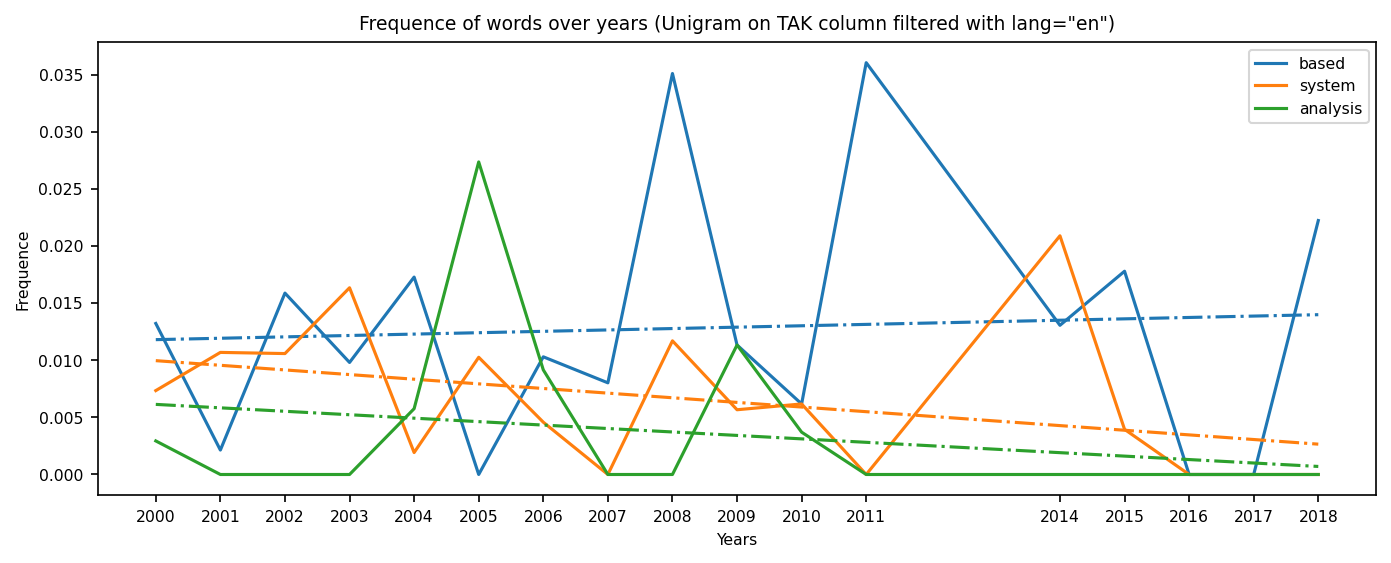

In [44]:
# Create a dict to store top words frequencies by year
top_words_all = top_words
top_freqs_all = get_words_freq(unigram_corpus_en, 'tak', top_words)
top_freqs_by_year = {word: [] for word in top_words_all}

# iterate by year to get all the word frequencie within this year
for year in years:
    mask_year = unigram_corpus_en.date == year
    # get the frequencies
    freqs_year = get_words_freq(unigram_corpus_en, 'tak', top_words, df_mask=mask_year)
    for word, freq in zip(top_words_all, freqs_year):
        top_freqs_by_year[word].append(freq)


exemple_words = top_words_all[:9:3]
for i, word in enumerate(exemple_words):
    plt.plot(years, top_freqs_by_year[word], label=word)
    # add regression line
    plot_add_regression_line(years, top_freqs_by_year[word], plt.default_colors[i]) 
plt.title('Frequence of words over years (Unigram on TAK column filtered with lang="en")')
plt.xticks(years, years)
plt.xlabel('Years')
plt.ylabel('Frequence')
plt.legend()
pass


#### Plus grandes augmentations de fréquence 
Maintenant que nous avons les evolutions de chaque mot au cours du temps nous pouvons nous concentrer sur une simple regression linéaire et estimer alors lesquels mots sont de plus en plus fréquents et inversement

In [45]:
dict_slopes = {
    word: get_slope(years, top_freqs_by_year[word])
    for word in top_words_all
}

exemple_words = top_words_all[:9:3]
for word in exemple_words:
    print(f'The word "{word:8}" has a slope of {dict_slopes[word]:.5f}')
    

The word "based   " has a slope of 0.00012
The word "system  " has a slope of -0.00041
The word "analysis" has a slope of -0.00030


On peut donc savoir par exemple quels sont les 5 mots avec la meilleure évolution en terme de fréquence

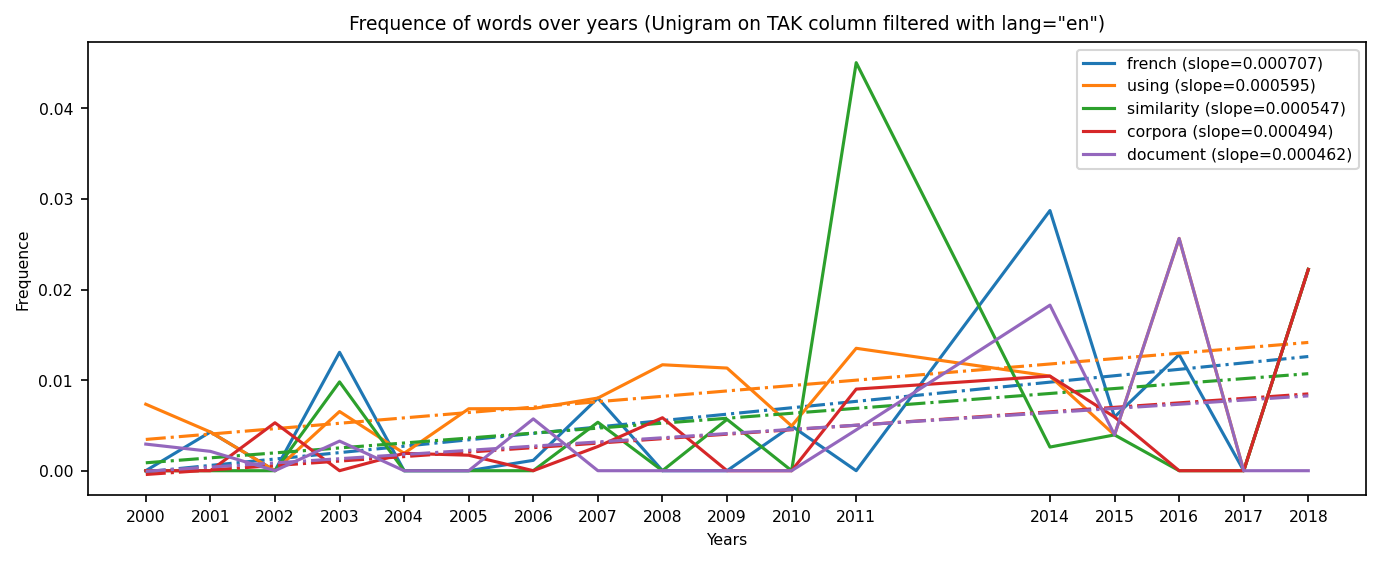

In [46]:
dict_slopes = {
    word: slope 
    for word, slope in sorted(
        dict_slopes.items(), 
        key=lambda item: item[1],
        reverse=True
    )
}
n_best = 5
for i, (word, slope) in enumerate(dict_slopes.items()):
    if not i < n_best:
        break
    plt.plot(years, top_freqs_by_year[word], label=f'{word} (slope={slope:6f})')
    # add regression line
    plot_add_regression_line(years, top_freqs_by_year[word], plt.default_colors[i]) 
plt.title('Frequence of words over years (Unigram on TAK column filtered with lang="en")')
plt.xticks(years, years)
plt.xlabel('Years')
plt.ylabel('Frequence')
plt.legend()
pass

Ici on a un corpus francais de texte traduits en anglais donc il n'est pas étonnant de retrouver le mot "french" et on retrouve les mots "corpora", "document".

#### Plus grandes diminutions de fréquence

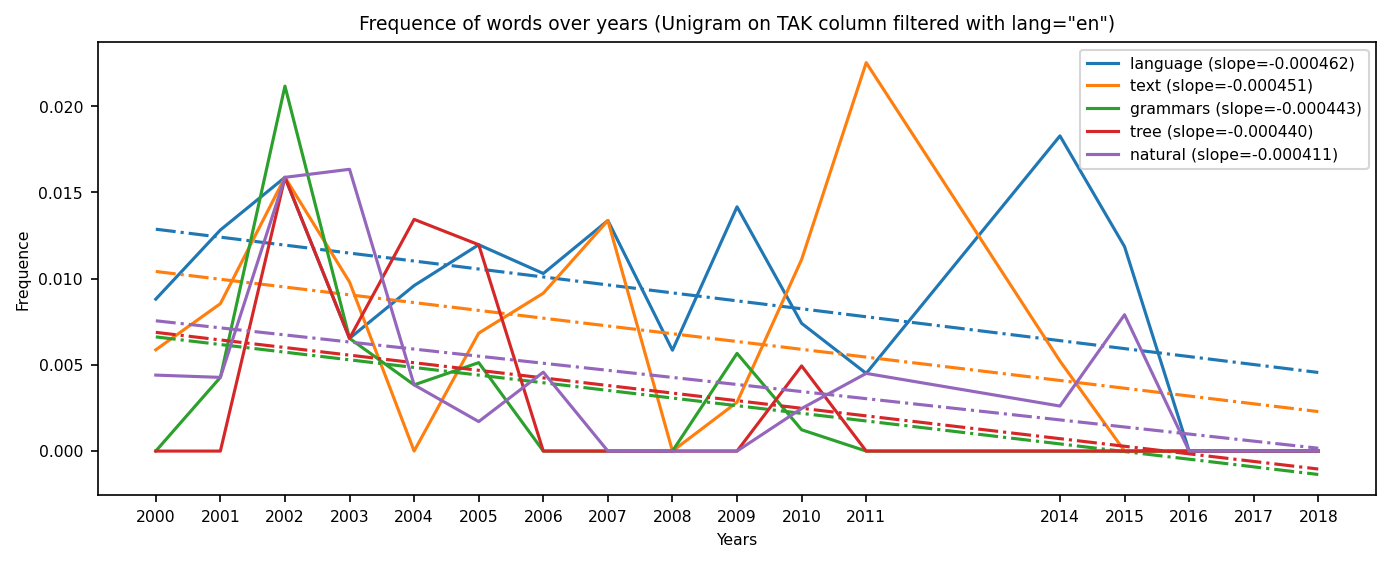

In [47]:
dict_slopes = {
    word: slope 
    for word, slope in sorted(
        dict_slopes.items(), 
        key=lambda item: item[1],
    )
}
n_best = 5
for i, (word, slope) in enumerate(dict_slopes.items()):
    if not i < n_best:
        break
    plt.plot(years, top_freqs_by_year[word], label=f'{word} (slope={slope:6f})')
    # add regression line
    plot_add_regression_line(years, top_freqs_by_year[word], plt.default_colors[i]) 

plt.title('Frequence of words over years (Unigram on TAK column filtered with lang="en")')
plt.xticks(years, years)
plt.xlabel('Years')
plt.ylabel('Frequence')
plt.legend()
pass

C'est intéressant de remarquer que l'on retrouve ici aussi le mot "grammars".

### Francais Bigram

Enfin nous analysons les bigram pour le corpus en francais. Nous ne le ferons pas pour le corpus en anglais puisqu'il est plus lacunaire donc la complexité avec des bigram en anglais ne serait pas très significative. 
Ceci étant dis, recommencons le process que l'on a déjà entammé par deux fois ci-dessus

#### Concatenation titre, abstract, keywords

(Comme pour la section Francais)


Nous allons donc nous créer une table dans laquelle nous ne garderons que les articles francais et nous y ajouterons une colonne qui concatène le titre, l'abstract et les keywords


In [48]:
pd.set_option('max_colwidth', 300)  # default = 50

bigram_corpus_fr = bigram_corpus[bigram_corpus.lang == 'fr']

# "tak" for title, abstract and keywords
cols = ['title', 'abstract_fr', 'keywords_fr']
bigram_corpus_fr['tak'] = bigram_corpus_fr[cols].apply(
    # flatten list of list x
    lambda x: [inner for outer in x for inner in outer]  
    , axis=1
)
bigram_corpus_fr[cols + ['tak']]


title  ...                                                                                                                                                                                                                                                                                                          tak
0                                     [elements conception, conception systeme, systeme interpretation, interpretation automatique, automatique textes, textes images]  ...  [elements conception, conception systeme, systeme interpretation, interpretation automatique, automatique textes, textes images, considerons travail, travail tache, tache traitement, traitement automatique, automatique visant, visant a, a construire, construire a, a partir, partir textes, textes...
1                                                                                     [informatisation dictionnaire, dictionnaire explicatif, explicatif combinatoire]  ...  [informatisation dictionnaire, dictionnaire explicatif, explicatif combinatoire, donnons ici, ici apercu, apercu logiciel, logiciel decid, decid developpe, developpe geta, geta afin, afin informatiser, informatiser processus, processus redaction, redaction dictionnaire, dictionnaire explicatif, ...
2              [construction representation, representation semantique, semantique graphes, graphes conceptuels, conceptuels a, a partir, partir analyse, analyse lfg]  ...  [construction representation, representation semantique, semantique graphes, graphes conceptuels, conceptuels a, a partir, partir analyse, analyse lfg, diverses methodes, methodes ete, ete proposees, proposees construire, construire graphe, graphe conceptuel, conceptuel representant, representan...
3                                                                                                           [systemes types, types lambda, lambda drt, drt ascendante]  ...  [systemes types, types lambda, lambda drt, drt ascendante, terme lambda, lambda drt, drt designe, designe ensemble, ensemble methodes, methodes permettant, permettant construire, construire representations, representations semantiques, semantiques drs, drs a, a partir, partir arbres, arbres synt...
4                                                                  [grammaire tag, tag vue, vue comme, comme grammaire, grammaire sens, sens texte, texte precompilee]  ...  [grammaire tag, tag vue, vue comme, comme grammaire, grammaire sens, sens texte, texte precompilee, cet article, article comparons, comparons deux, deux modeles, modeles linguistiques, linguistiques utilises, utilises tal, tal grammaires, grammaires arbres, arbres adjoints, adjoints tag, tag the...
...                                                                                                                                                                ...  ...                                                                                                                                                                                                                                                                                                          ...
1597  [curriculum apprentissage, apprentissage reconnaissance, reconnaissance entites, entites nommees, nommees extraction, extraction concepts, concepts semantiques]  ...  [curriculum apprentissage, apprentissage reconnaissance, reconnaissance entites, entites nommees, nommees extraction, extraction concepts, concepts semantiques, cet article, article presentons, presentons approche, approche bout, bout bout, bout extraction, extraction concepts, concepts semantiq...
1598                                                                                   [detection ellipses, ellipses corpus, corpus sous, sous titres, titres anglais]  ...  [detection ellipses, ellipses corpus, corpus sous, sous titres, titres anglais, cet article, article presente, presente methodologie, methodologie detection, detection ellipses, ellipses anglais, anglais 

#### Top 100 mots anglais


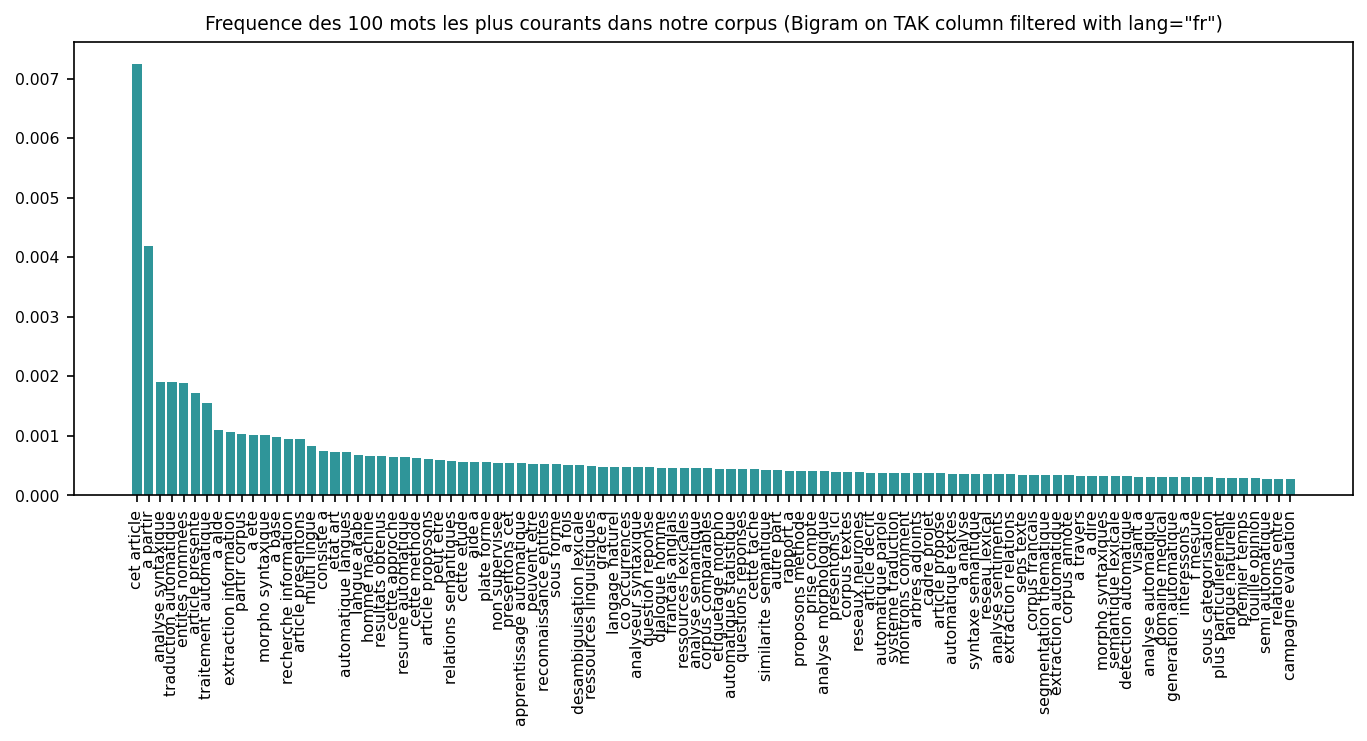

In [49]:
top_n = 100
top_words, top_freqs = get_top(bigram_corpus_fr, 'tak', top_n, to_freq=True)

plt.title(f'Frequence des {len(top_words)} mots les plus courants dans notre corpus (Bigram on TAK column filtered with lang="fr")')
plt.bar(range(len(top_words)), top_freqs, color='#2f9599')
plt.xticks(range(len(top_words)), top_words, rotation='vertical')
pass

Pareil que pour le cas des données en francais en unigram, nous pouvons remarquer que le vocabulaire utilisé dans ce corpus est très technique et spécialisé en NLP.
Mais il est beaucoup plus technique et spécialisé en bigram qu'en unigram grâce à l'association des mots. 
Ici, plus aucun doute, il s'agit à coup sûr d'un corpus de publication de NLP dont le premier bigram est d'ailleurs "cet article"



#### Evolution des 100 premiers mots dans le temps

(Comme pour le cas francais)

Nous avons dressé le top 100 des mots les plus fréquents et nous allons analyser leur évolutions.

In [50]:
# get all the years in the corpus from 2000
years =np.array([year for year in bigram_corpus_fr.date.unique() if year > 1999])

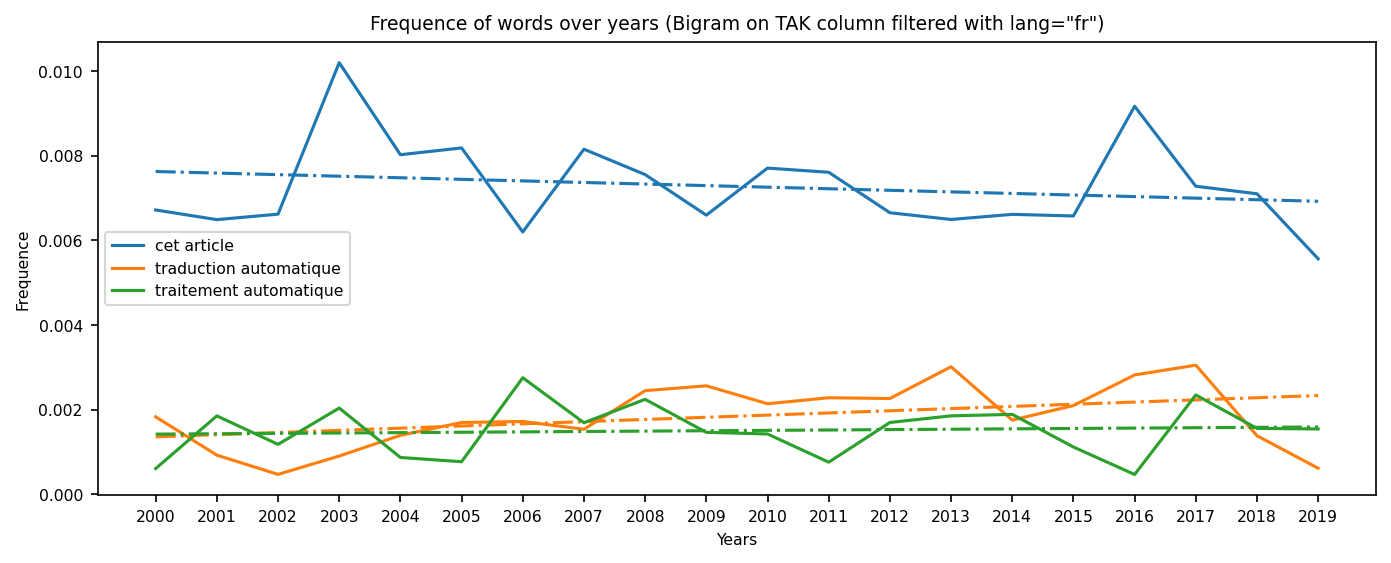

In [51]:
# Create a dict to store top words frequencies by year
top_words_all = top_words
top_freqs_all = get_words_freq(bigram_corpus_fr, 'tak', top_words)
top_freqs_by_year = {word: [] for word in top_words_all}

# iterate by year to get all the word frequencie within this year
for year in years:
    mask_year = bigram_corpus_fr.date == year
    # get the frequencies
    freqs_year = get_words_freq(bigram_corpus_fr, 'tak', top_words, df_mask=mask_year)
    for word, freq in zip(top_words_all, freqs_year):
        top_freqs_by_year[word].append(freq)

exemple_words = top_words_all[:9:3]
for i, word in enumerate(exemple_words):
    plt.plot(years, top_freqs_by_year[word], label=word)
    # add regression line
    plot_add_regression_line(years, top_freqs_by_year[word], plt.default_colors[i]) 
plt.title('Frequence of words over years (Bigram on TAK column filtered with lang="fr")')
plt.xticks(years, years)
plt.xlabel('Years')
plt.ylabel('Frequence')
plt.legend()
pass


#### Plus grandes augmentations de fréquence 
Maintenant que nous avons les evolutions de chaque mot au cours du temps nous pouvons nous concentrer sur une simple regression linéaire et estimer alors lesquels mots sont de plus en plus fréquents et inversement

In [52]:
dict_slopes = {
    word: get_slope(years, top_freqs_by_year[word])
    for word in top_words_all
}

exemple_words = top_words_all[:9:3]
for word in exemple_words:
    print(f'The word "{word:8}" has a slope of {dict_slopes[word]:.5f}')
    

The word "cet article" has a slope of -0.00004
The word "traduction automatique" has a slope of 0.00005
The word "traitement automatique" has a slope of 0.00001


On peut donc savoir par exemple quels sont les 5 mots avec la meilleure évolution en terme de fréquence

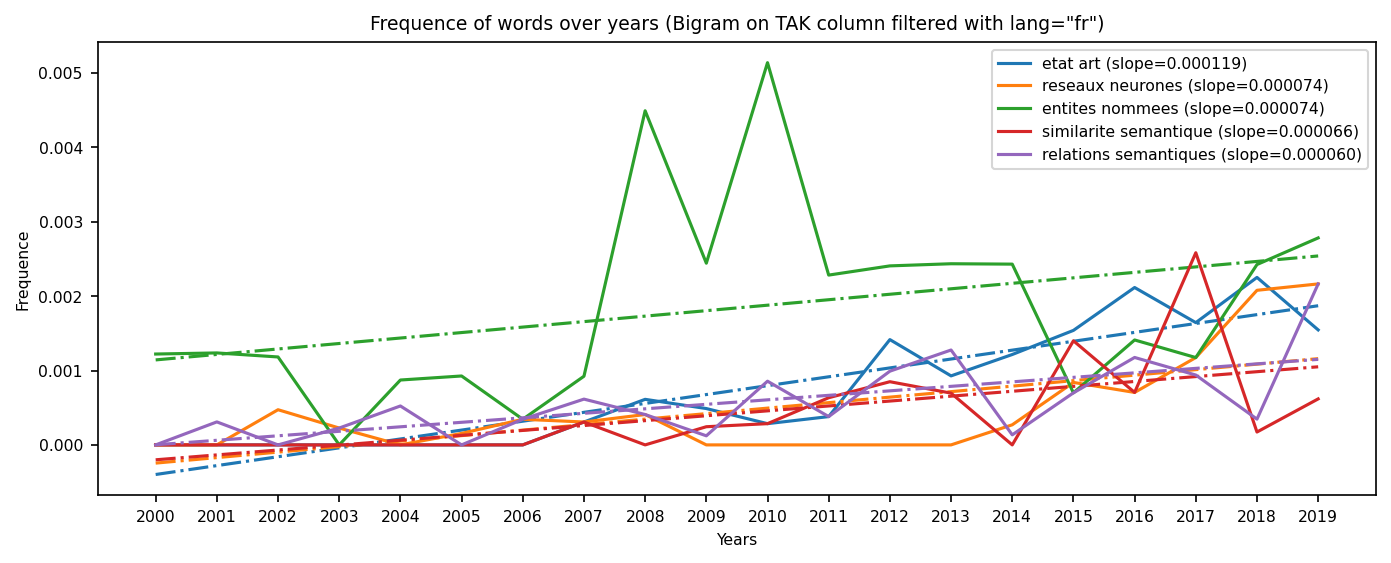

In [53]:
dict_slopes = {
    word: slope 
    for word, slope in sorted(
        dict_slopes.items(), 
        key=lambda item: item[1],
        reverse=True
    )
}
n_best = 5
for i, (word, slope) in enumerate(dict_slopes.items()):
    if not i < n_best:
        break
    plt.plot(years, top_freqs_by_year[word], label=f'{word} (slope={slope:6f})')
    # add regression line
    plot_add_regression_line(years, top_freqs_by_year[word], plt.default_colors[i]) 

plt.title('Frequence of words over years (Bigram on TAK column filtered with lang="fr")')
plt.xticks(years, years)
plt.xlabel('Years')
plt.ylabel('Frequence')
plt.legend()
pass

Beaucoup plus intéressant que pour les unigram, ici on voit carrément la mentalité des publications de recherche ressortir (en extrapolant sur notre vécu)
Il est plus qu'évident que la comparaison à l'état de l'art est une tendance qui est de plus en plus forte. De même pour les réseaux neuronnaux et la recherche de sémantique dans du non supervisé et d'entité dans du non structuré (ce qui est d'ailleurs permis par les réseaux neuronaux).

#### Plus grandes diminutions de fréquence

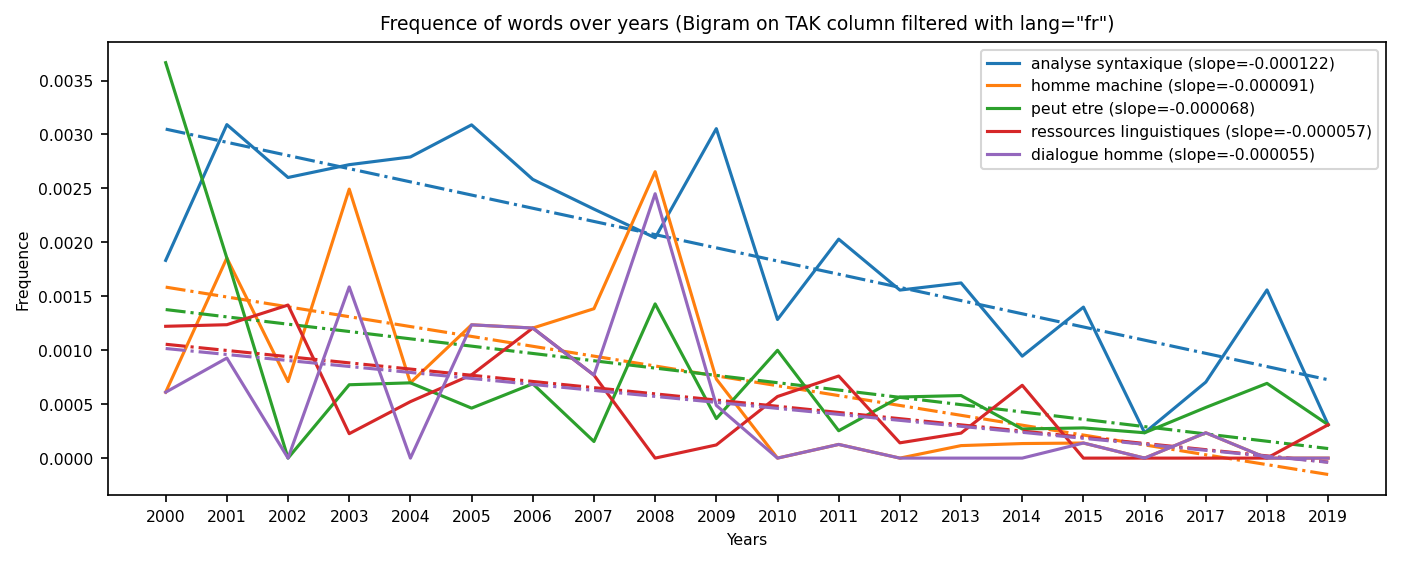

In [54]:
dict_slopes = {
    word: slope 
    for word, slope in sorted(
        dict_slopes.items(), 
        key=lambda item: item[1],
    )
}
n_best = 5
for i, (word, slope) in enumerate(dict_slopes.items()):
    if not i < n_best:
        break
    plt.plot(years, top_freqs_by_year[word], label=f'{word} (slope={slope:6f})')
    # add regression line
    plot_add_regression_line(years, top_freqs_by_year[word], plt.default_colors[i]) 

plt.title('Frequence of words over years (Bigram on TAK column filtered with lang="fr")')
plt.xticks(years, years)
plt.xlabel('Years')
plt.ylabel('Frequence')
plt.legend()
pass

Pareil que la dernière fois, il est difficile de comprendre pourquoi tel ou tel bigram baisse. Mais c'est amusant ce remarquer que le "peut être" perd sa place dans les publications de recherche.
On peut tout de même faire aussi l'extrapolation faite plus haut disant que l'analyse syntaxique disparait au profit de l'automatisation et l'apprentissage automatique

## K-Means Clustering

Maintenant que nous avons un apercu sur les mots les plus courants et les évolutions respectives sur les titres, les abstracts, les keywords, pour les unigram, les bigrams, en francais et anglais, nous voulons essayer de créer des clusters de ces articles. 
Nous sommes conscients que lors du cours nous n'avons pas vu le K-Means clustering mais nous voulions l'utiliser pour le comparer par la suite à ce que l'on a fait en cours. 
Nous ne traiterons plus ni le titre, ni les keywords, ni les abstracts mais nous traiterons les contenus à partir de maintenant.
Il permettrons de pouvoir utiliser convenablement cette algortihme sans trop se soucier de la complexité du vocabulaire comparé à la taille de notre corpus. 

### Francais Unigram contenus

In [55]:
pd.set_option('max_colwidth', 100)  # default = 50
content_fr = corpus[corpus.lang == 'fr'][["content"]]
content_fr

content
0     modele grammaire applicative cognitive ga postule trois niveaux derepresentations niveau phenoty...
1     domaine ingenierie linguistique connaissance probleme desressources lexicales linguistiques touj...
2                                                                                                        
3     theorie representations discursives drt introduite hans kamp a ete elaboree cadre semantique for...
4     tag formalisme initialement developpe cadre theorie langages formels dont pertinence representat...
...                                                                                                   ...
1597  apprentissage humain realise etapes successives plus plus complexes permettant ainside aborder n...
1598  ellipse renvoie a incompletude syntaxique phrase presente incidence latransmission contenu seman...
1599  generation automatique poesie tache ardue systeme informatique unpoeme sens important prendre co...
1600  etiquetage sequences probleme important tal nombreux problemes pouvant etremodelises comme etiqu...
1601  expressions polylexicales ep constituent classe objets linguistiques inclut expressions idiomati...

[1502 rows x 1 columns]

#### TF-IDF


In [56]:
# Applying TFIDF 
vectorizer = TfidfVectorizer(ngram_range=(1,1)) 
tfidf = vectorizer.fit_transform(content_fr["content"]).toarray()
tfidf.shape

(1502, 140497)

La taille de (1502, 140497) est très très importante. Ce qui implique que si nous voulons créer un dataframe avec autant de valeurs alors nous serons confrontés à un problème de RAM dans le notebook. Réduisons alors le vecteur au top 5000 unigram du corpus

In [57]:
max_features = 5000

vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=max_features) 
tfidf = vectorizer.fit_transform(content_fr["content"]).toarray()
content_fr['tfidf'] = tfidf.tolist()
content_fr

content                                                                                                tfidf
0     modele grammaire applicative cognitive ga postule trois niveaux derepresentations niveau phenoty...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.01788852834198173, 0.0, 0.022223188088994986, 0.01889878767723769, 0...
1     domaine ingenierie linguistique connaissance probleme desressources lexicales linguistiques touj...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.01252368501838991, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.029415169504...
2                                                                                                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3     theorie representations discursives drt introduite hans kamp a ete elaboree cadre semantique for...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.007939610359517117, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00868411308860546, 0....
4     tag formalisme initialement developpe cadre theorie langages formels dont pertinence representat...  [0.0, 0.0, 0.04728163819675715, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
...                                                                                                   ...                                                                                                  ...
1597  apprentissage humain realise etapes successives plus plus complexes permettant ainside aborder n...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.009581869676603868, 0.0, 0.0, 0.010123008282582826, 0.0, 0.0, 0.0, 0...
1598  ellipse renvoie a incompletude syntaxique phrase presente incidence latransmission contenu seman...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.019787297188850646, 0.0...
1599  generation automatique poesie tache ardue systeme informatique unpoeme sens important prendre co...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.02586952967055439, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1600  etiquetage sequences probleme important tal nombreux problemes pouvant etremodelises comme etiqu...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1601  expressions polylexicales ep constituent classe objets linguistiques inclut expressions idiomati...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.006130479266833942, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004094...

[1502 rows x 2 columns]

#### K-Means et Elbow method

Pour choisir notre k (hyperparamètre du K-Means), nous allons procéder à une elbow method. Pour faire simple, il s'agit de tester toutes les valeurs de k sur un intervalle (nous choissirons de 1 à 15) et d'évaluer à l'oeil nu quel valeur de k semble la plus pertinente. Généralement on choisit comme valeur de k, la valeur à laquelle la courbe est en forme de coude, d'où le nom de la méthode. 

In [58]:
%%time

sum_squared_dists = []
k_range = range(1,15)
for k in k_range:
    print(f'Performing {k}-Means...')
    kmeans = KMeans(
        n_clusters=k,
        n_init=10, # number of different initialization (keep best)
        max_iter=200,
        random_state=42
    )
    kmeans = kmeans.fit(np.array(list(content_fr.tfidf)))
    sum_squared_dists.append(kmeans.inertia_)
    print(f'\tInertia : {kmeans.inertia_:8.2f} after {kmeans.n_iter_:3} iterations')
    

Performing 1-Means...
	Inertia :  1189.71 after   2 iterations
Performing 2-Means...
	Inertia :  1171.26 after   7 iterations
Performing 3-Means...
	Inertia :  1157.21 after  25 iterations
Performing 4-Means...
	Inertia :  1145.85 after  31 iterations
Performing 5-Means...
	Inertia :  1138.02 after  19 iterations
Performing 6-Means...
	Inertia :  1131.08 after  11 iterations
Performing 7-Means...
	Inertia :  1123.63 after  18 iterations
Performing 8-Means...
	Inertia :  1115.21 after  36 iterations
Performing 9-Means...
	Inertia :  1109.73 after  27 iterations
Performing 10-Means...
	Inertia :  1128.92 after  55 iterations
Performing 11-Means...
	Inertia :  1127.46 after  55 iterations
Performing 12-Means...
	Inertia :  1121.02 after  51 iterations
Performing 13-Means...
	Inertia :  1118.90 after  56 iterations
Performing 14-Means...
	Inertia :  1112.33 after  57 iterations
CPU times: user 2min 22s, sys: 20.8 s, total: 2min 43s
Wall time: 2min 9s


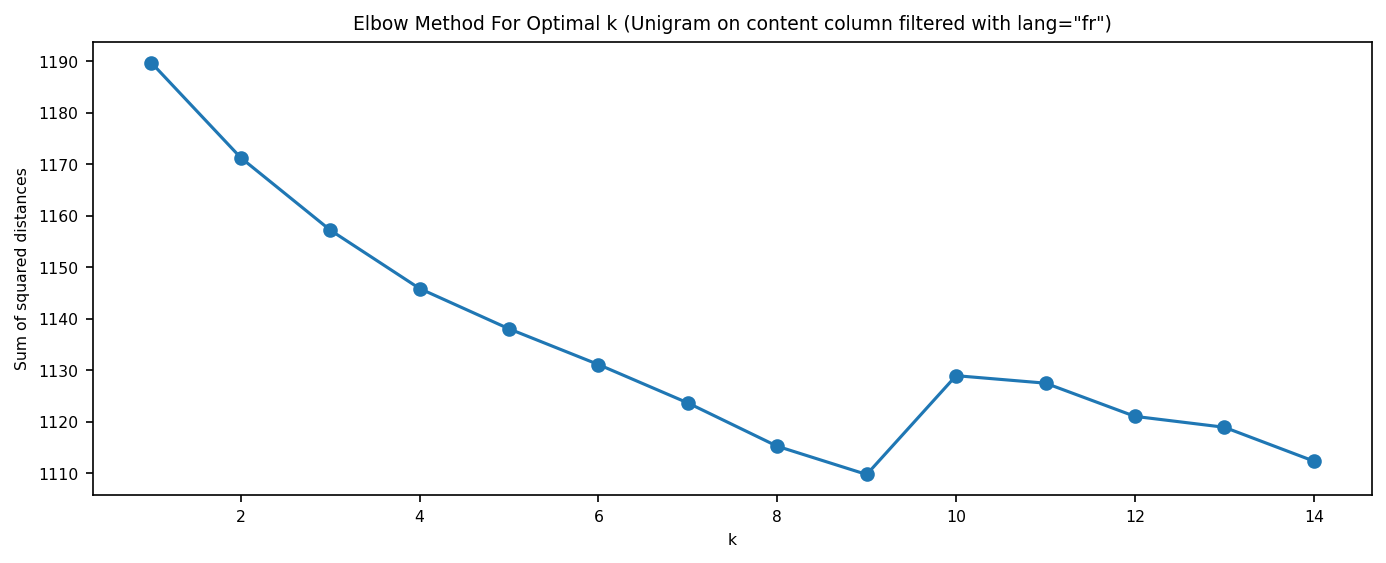

In [59]:
plt.plot(k_range, sum_squared_dists, '-o')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k (Unigram on content column filtered with lang="fr")')
plt.show()

En l'occurence, il est ici difficile de choisir une bonne valeur de k. On peut remarquer qu'avec l'augmentation de k, il n'y a pas de réelle et forte diminution de l'erreur au carrée. D'ailleurs, on ne remarque pas de coude sur cette courbe alors nous choissirons pour la suite la valeur de k=6.

#### K-Means et nuage de mots

On fit alors notre algo KMeans pour trouver k=6 clusters dans nos contenus. 

In [60]:
%%time
true_k = 6
kmeans = KMeans(
    n_clusters=true_k, 
    init='k-means++', 
    max_iter=200, 
    n_init=20,
    random_state=42
)
kmeans.fit(np.array(list(content_fr.tfidf)))

CPU times: user 17 s, sys: 2.74 s, total: 19.7 s
Wall time: 15.4 s


In [61]:
content_fr['cluster'] = list(kmeans.labels_)
content_fr

content  ... cluster
0     modele grammaire applicative cognitive ga postule trois niveaux derepresentations niveau phenoty...  ...       4
1     domaine ingenierie linguistique connaissance probleme desressources lexicales linguistiques touj...  ...       5
2                                                                                                          ...       0
3     theorie representations discursives drt introduite hans kamp a ete elaboree cadre semantique for...  ...       5
4     tag formalisme initialement developpe cadre theorie langages formels dont pertinence representat...  ...       5
...                                                                                                   ...  ...     ...
1597  apprentissage humain realise etapes successives plus plus complexes permettant ainside aborder n...  ...       4
1598  ellipse renvoie a incompletude syntaxique phrase presente incidence latransmission contenu seman...  ...       5
1599  generation automatique poesie tache ardue systeme informatique unpoeme sens important prendre co...  ...       2
1600  etiquetage sequences probleme important tal nombreux problemes pouvant etremodelises comme etiqu...  ...       2
1601  expressions polylexicales ep constituent classe objets linguistiques inclut expressions idiomati...  ...       2

[1502 rows x 3 columns]

Maintentant que nous avons crée k= clusters dans nos contenus, nous pouvons alors faire une visualisation sous forme de nuage de mot pour chacun de ces clusters. 

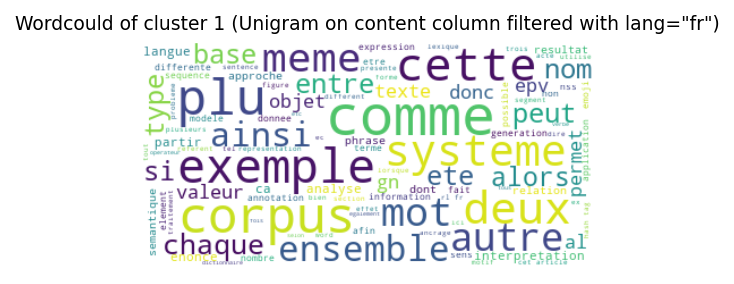

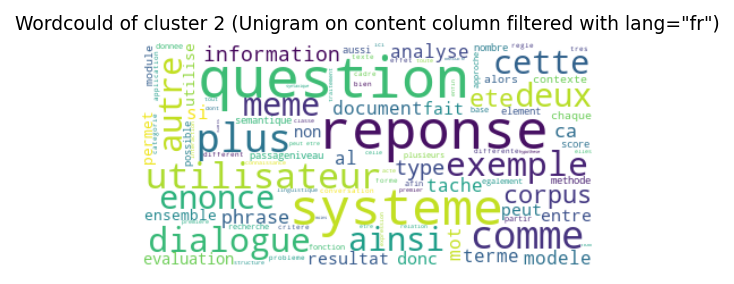

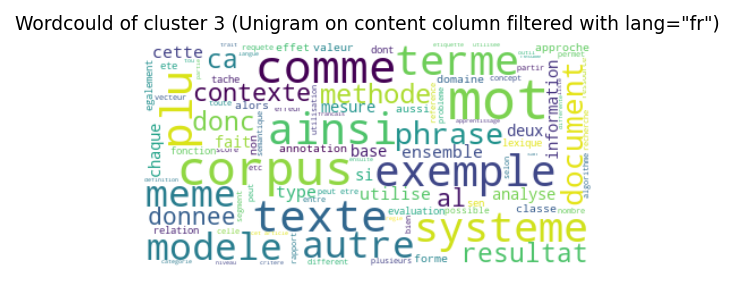

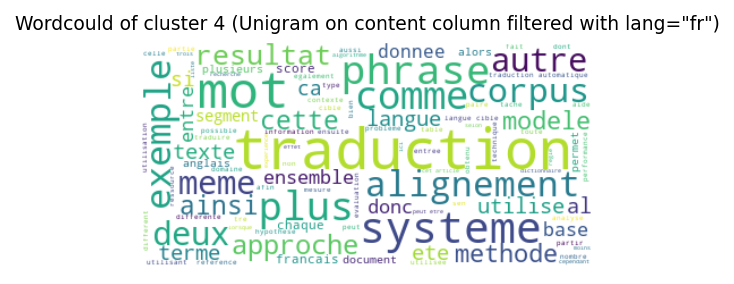

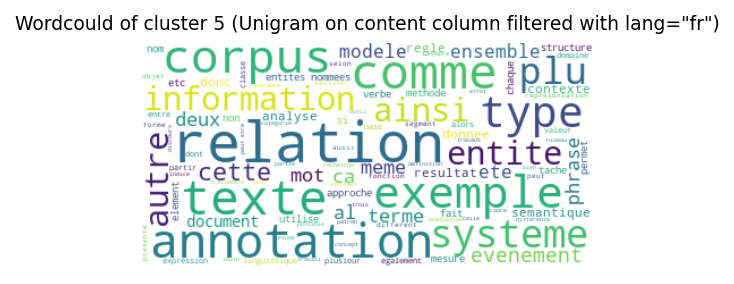

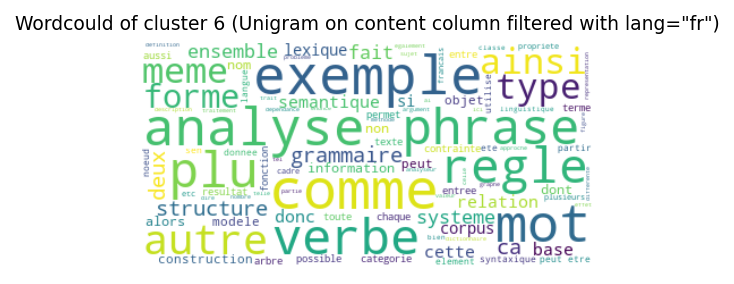

In [62]:

plt.rcParams['figure.figsize'] = [4, 2]

for k in range(0, true_k):
    k_content = content_fr[content_fr.cluster==k]
    text = k_content['content'].str.cat(sep=' ')    
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

    plt.figure()

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f'Wordcould of cluster {k+1} (Unigram on content column filtered with lang="fr")')
    plt.axis("off")
    plt.show()


plt.rcParams['figure.figsize'] = [11, 4]

On peut alors constater, qu'en majorité, ce sont les mêmes mots qui reviennent dans notre contenu. L'analyse KMeans sur le contenu n'est pas aussi pertinente que nous l'espérions. On peut tout de même remarquer quelques clusters :
- Les publications sur les corpus et ensembles
- Les publications sur les chatbots (questions-réponse)
- Les publications sur les corpus et leur composition / comparaisons (mots /textes / termes)
- Les publications sur la traduction 
- Les publications sur les enjeux d'annotations et de relations entre les données
- Les publications sur des exemples plus analytiques et régies par des règles


### Francais Unigram titres

Finalement, nous voulions traiter nos contenus et les analyser avec KMeans mais cela s'est révélé peu satisfaisant selon nous. Alors on est en droit de se demander si cet algorithme est pertinent pour ce corpus ou si c'est le contenu qui est trop complexe pour l'algorithme. Pour répondre à cette question, nous allons faire la même analyse mais avec les titres et non les contenus.

In [63]:
pd.set_option('max_colwidth', 100)  # default = 50
title_fr = corpus[corpus.lang == 'fr'][["title"]]
title_fr

title
0                        elements conception systeme interpretation automatique textes images
1                                        informatisation dictionnaire explicatif combinatoire
2             construction representation semantique graphes conceptuels a partir analyse lfg
3                                                        systemes types lambda drt ascendante
4                                    grammaire tag vue comme grammaire sens texte precompilee
...                                                                                       ...
1597  curriculum apprentissage reconnaissance entites nommees extraction concepts semantiques
1598                                            detection ellipses corpus sous titres anglais
1599                                                   generation automatique poesie francais
1600                  modeles neuronaux hybrides modelisation sequences meilleur trois mondes
1601                                    polylexfle base donnees expressions polylexicales fle

[1502 rows x 1 columns]

#### TF-IDF


In [64]:
# Applying TFIDF 
vectorizer = TfidfVectorizer(ngram_range=(1,1)) 
tfidf = vectorizer.fit_transform(title_fr["title"]).toarray()
tfidf.shape

(1502, 2713)

La taille de (1502, 2713) est clairement moins importante que celle avec le contenu de (1502, 140497) alors nous ne mettons pas de max_features=5000. Cela nous rassure dans le sens où nous cherchions à réduire la complexité du vocabulaire pour utiliser .

In [65]:

vectorizer = TfidfVectorizer(ngram_range=(1,1)) 
tfidf = vectorizer.fit_transform(title_fr["title"]).toarray()
title_fr['tfidf'] = tfidf.tolist()
title_fr

title                                                                                                tfidf
0                        elements conception systeme interpretation automatique textes images  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1                                        informatisation dictionnaire explicatif combinatoire  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2             construction representation semantique graphes conceptuels a partir analyse lfg  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3                                                        systemes types lambda drt ascendante  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4                                    grammaire tag vue comme grammaire sens texte precompilee  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
...                                                                                       ...                                                                                                  ...
1597  curriculum apprentissage reconnaissance entites nommees extraction concepts semantiques  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1598                                            detection ellipses corpus sous titres anglais  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1599                                                   generation automatique poesie francais  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1600                  modeles neuronaux hybrides modelisation sequences meilleur trois mondes  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1601                                    polylexfle base donnees expressions polylexicales fle  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

[1502 rows x 2 columns]

#### K-Means et Elbow method

In [66]:
%%time

sum_squared_dists = []
k_range = range(1,15)
for k in k_range:
    print(f'Performing {k}-Means...')
    kmeans = KMeans(
        n_clusters=k,
        n_init=20, # number of different initialization (keep best)
        max_iter=200,
        random_state=42
    )
    kmeans = kmeans.fit(np.array(list(title_fr.tfidf)))
    sum_squared_dists.append(kmeans.inertia_)
    print(f'\tInertia : {kmeans.inertia_:8.2f} after {kmeans.n_iter_:3} iterations')
    

Performing 1-Means...
	Inertia :  1484.68 after   2 iterations
Performing 2-Means...
	Inertia :  1474.40 after   6 iterations
Performing 3-Means...
	Inertia :  1466.20 after   6 iterations
Performing 4-Means...
	Inertia :  1455.78 after   9 iterations
Performing 5-Means...
	Inertia :  1450.08 after  18 iterations
Performing 6-Means...
	Inertia :  1444.42 after  43 iterations
Performing 7-Means...
	Inertia :  1438.39 after  19 iterations
Performing 8-Means...
	Inertia :  1431.48 after  11 iterations
Performing 9-Means...
	Inertia :  1427.66 after  13 iterations
Performing 10-Means...
	Inertia :  1423.93 after  14 iterations
Performing 11-Means...
	Inertia :  1418.89 after  11 iterations
Performing 12-Means...
	Inertia :  1415.83 after  12 iterations
Performing 13-Means...
	Inertia :  1410.39 after  14 iterations
Performing 14-Means...
	Inertia :  1407.34 after  13 iterations
CPU times: user 2min 52s, sys: 35 s, total: 3min 27s
Wall time: 2min 37s


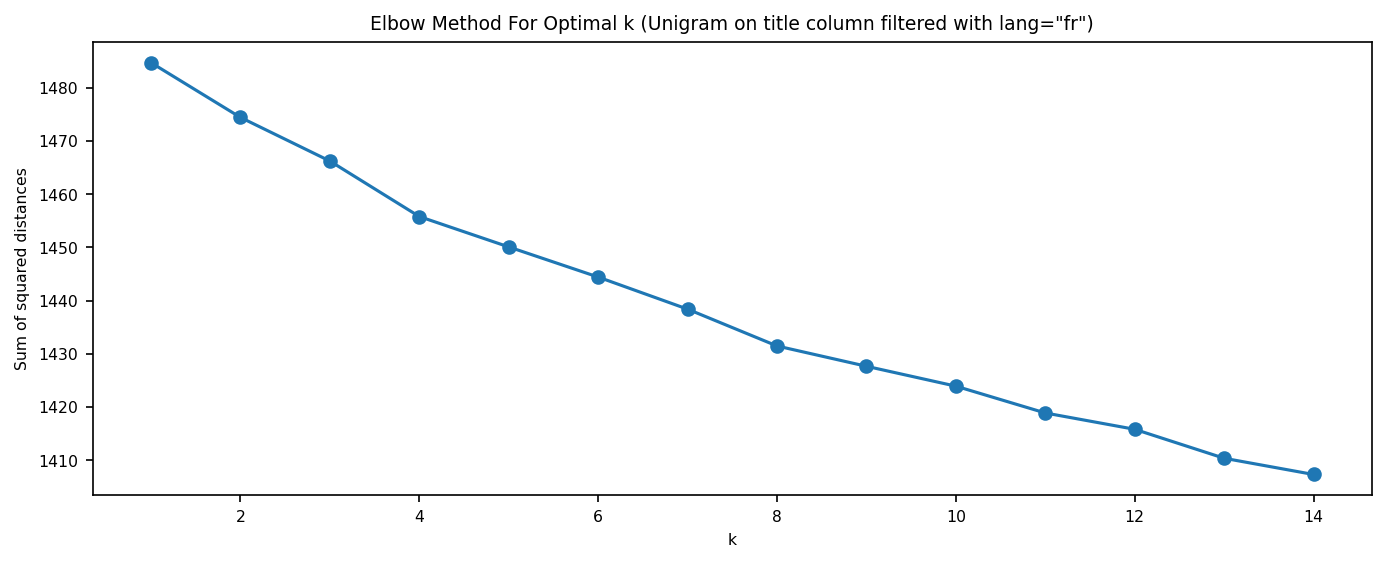

In [67]:
plt.plot(k_range, sum_squared_dists, '-o')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k (Unigram on title column filtered with lang="fr")')
plt.show()

Comme pour le contenu, on remarque que la méthode du coude n'est pas très efficace pour ces données. Il y a une erreur inversement proportionnelle à la valeur de k. Alors dans un soucis de comparaison (arbitraire), nous resterons sur k=6.

#### K-Means et nuage de mots

In [68]:
%%time
true_k = 6
kmeans = KMeans(
    n_clusters=true_k, 
    init='k-means++', 
    max_iter=200, 
    n_init=20,
    random_state=42
)
kmeans.fit(np.array(list(title_fr.tfidf)))

CPU times: user 11.8 s, sys: 2.52 s, total: 14.3 s
Wall time: 10.9 s


In [69]:
title_fr['cluster'] = list(kmeans.labels_)
title_fr

title  ... cluster
0                        elements conception systeme interpretation automatique textes images  ...       2
1                                        informatisation dictionnaire explicatif combinatoire  ...       1
2             construction representation semantique graphes conceptuels a partir analyse lfg  ...       3
3                                                        systemes types lambda drt ascendante  ...       1
4                                    grammaire tag vue comme grammaire sens texte precompilee  ...       1
...                                                                                       ...  ...     ...
1597  curriculum apprentissage reconnaissance entites nommees extraction concepts semantiques  ...       5
1598                                            detection ellipses corpus sous titres anglais  ...       0
1599                                                   generation automatique poesie francais  ...       2
1600                  modeles neuronaux hybrides modelisation sequences meilleur trois mondes  ...       1
1601                                    polylexfle base donnees expressions polylexicales fle  ...       1

[1502 rows x 3 columns]

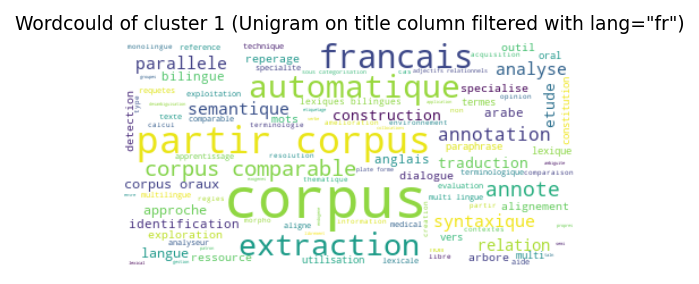

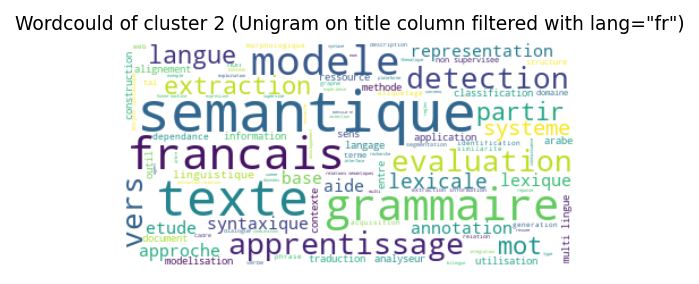

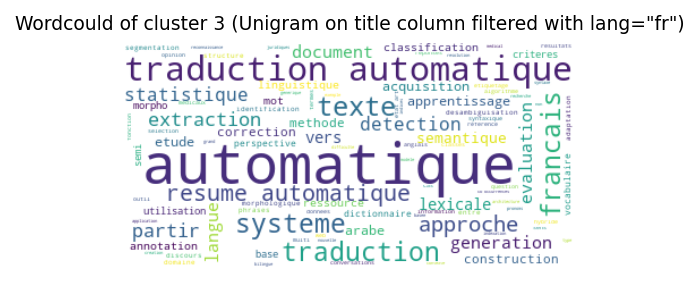

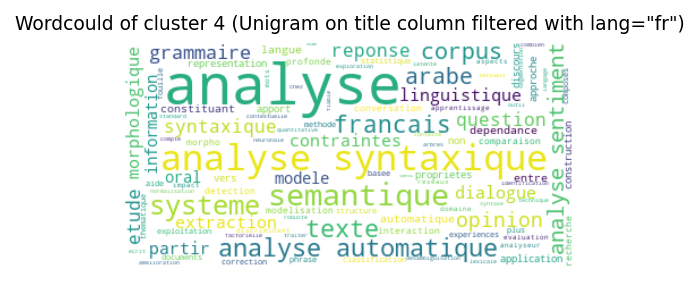

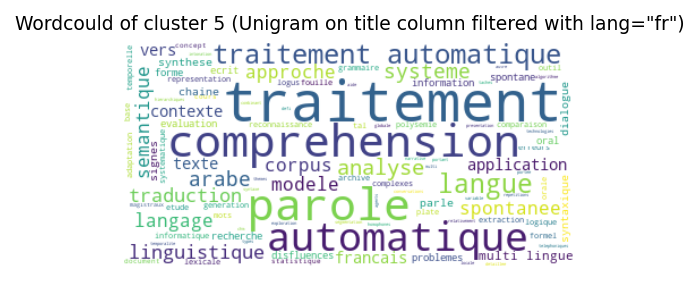

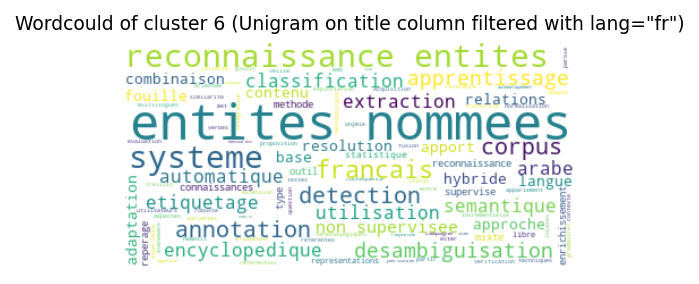

In [70]:

plt.rcParams['figure.figsize'] = [4, 2]

for k in range(0, true_k):
    k_content = title_fr[title_fr.cluster==k]
    text = k_content['title'].str.cat(sep=' ')    
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

    plt.figure()

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f'Wordcould of cluster {k+1} (Unigram on title column filtered with lang="fr")')
    plt.axis("off")
    plt.show()


plt.rcParams['figure.figsize'] = [11, 4]

Finalement, KMeans sur les titres est beaucoup plus pertinent que sur le contenu. Ici on peut retrouver 6 thèmes bien différents pour chacun de ces 6 clusters :
- Les publications sur les corpus
- Les publications sur la sémantique et la grammaire
- Les publications sur la traduction automatique
- Les publications sur l'analyse sémantique et syntaxique
- Les publications sur la comphrésion de la parole (chatbot)
- Les publications sur les entités nommées

On peut alors conclure en un sens que la complexité du vocabulaire joue un rôle primordial sur l'efficience du KMeans. Donc le titre est plus pertinent que le contenu dans ce cas. Alors en ce sens nous n'étudierons pas les bigrams pour la partie KMeans.
De la même facon avec seulement 100 publications anglaises, la complexité du vocabulaire par rapport à la taille du jeu de donnée sera peut être trop importante pour utiliser un KMeans. Mais essayons...

### Anglais Unigram titres

Pour finir nos comparaison, et puisque les bigram rendront le vocabulaire trop complexe pour utiliser un KMeans, nous regarderons seulement si une comparaison est faisable pour les titres en anglais unigram par rapport aux titre unigram en francais. Nous chois

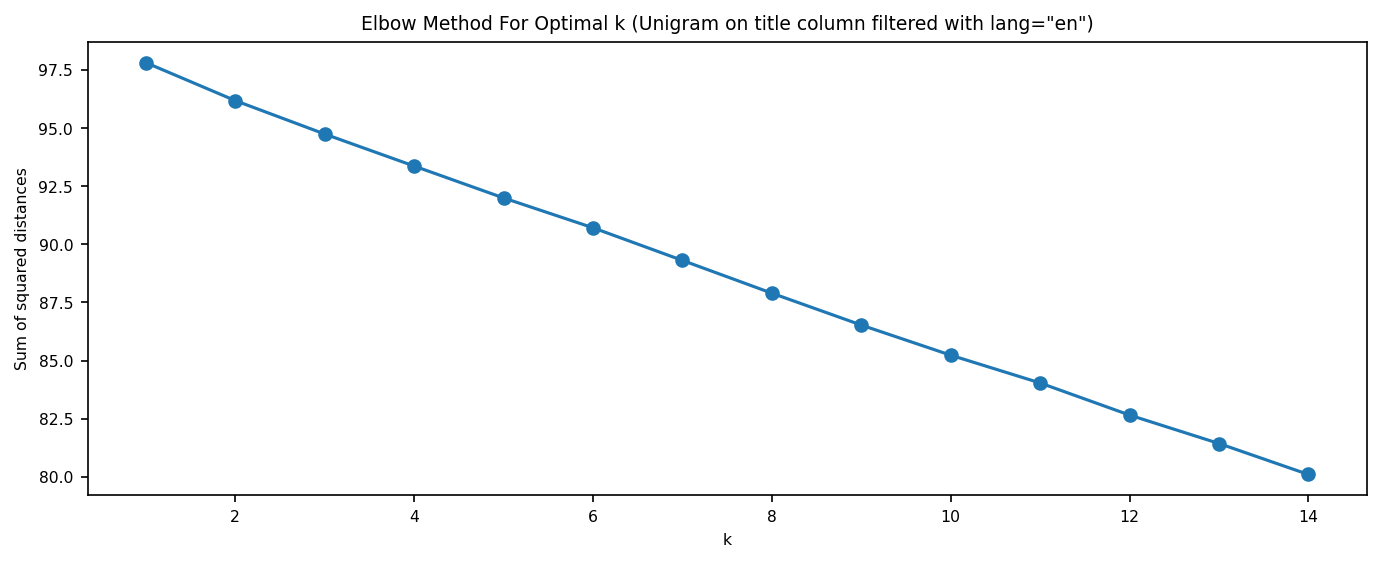

In [71]:
# Get TFIDF
pd.set_option('max_colwidth', 100)  # default = 50
title_en = corpus[corpus.lang == 'en'][["title"]]

# Applying TFIDF 
vectorizer = TfidfVectorizer(ngram_range=(1,1)) 
tfidf = vectorizer.fit_transform(title_en["title"]).toarray()
title_en['tfidf'] = tfidf.tolist()


# elbow method

sum_squared_dists = []
k_range = range(1,15)
for k in k_range:
    kmeans = KMeans(
        n_clusters=k,
        n_init=20, # number of different initialization (keep best)
        max_iter=200,
        random_state=42
    )
    kmeans = kmeans.fit(np.array(list(title_en.tfidf)))
    sum_squared_dists.append(kmeans.inertia_)

plt.plot(k_range, sum_squared_dists, '-o')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k (Unigram on title column filtered with lang="en")')
plt.show()


Encore une fois, il n'y a pas de coude apparent alors nous allons abitrairement partir sur k=3 car nous n'avons que 100 lignes de titres en anglais. Donc partir sur plus que k=3 serait un peu de l'overfit selon nous. 

In [72]:
# Get the k clusters with KMeans
true_k = 3
# init
kmeans = KMeans(
    n_clusters=true_k, 
    init='k-means++', 
    max_iter=200, 
    n_init=20,
    random_state=42
)
# fit
kmeans.fit(np.array(list(title_en.tfidf)))
# set results
title_en['cluster'] = list(kmeans.labels_)

title_en.groupby(by='cluster').count()[['title']]

title
cluster       
0           57
1           27
2           16

Même avec peu de données, on peut dire que nos données ne sont pas trop mal réparties même si le cluster 0 prend plus de la moitié des titres anglais.

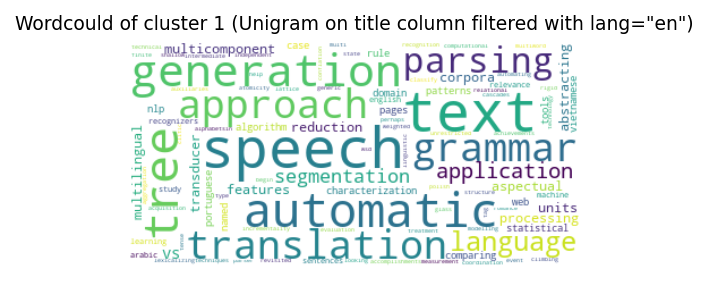

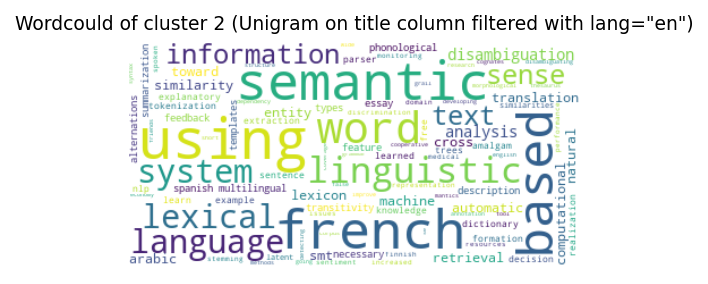

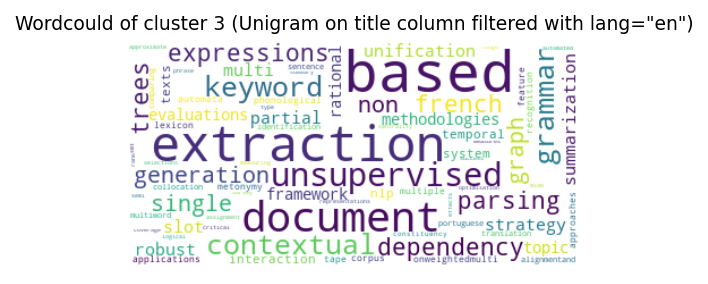

In [73]:
# word Clouds
plt.rcParams['figure.figsize'] = [4, 2]

for k in range(0, true_k):
    k_content = title_en[title_en.cluster==k]
    text = k_content['title'].str.cat(sep=' ')    
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

    plt.figure()

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f'Wordcould of cluster {k+1} (Unigram on title column filtered with lang="en")')
    plt.axis("off")
    plt.show()


plt.rcParams['figure.figsize'] = [11, 4]

C'est intéressant de remarque que l'on a les mêmes styles de clustes avec les titres en anglais et k=3 au lieu de k=6.
- Les publications sur l'automatisation / génération du texte.
- Les publications sur la sémantique
- Les publications sur les corpus et le non supervisé


## LDA

### Francais Unigram titre-abstract-keywords




#### Bag of Words et dictionnaire de corpus

In [74]:
data = list(unigram_corpus_fr[unigram_corpus_fr.lang == 'fr'].tak)
# get the dictionary of the corpus as token ids
corpus_dict = gensim.corpora.Dictionary(data)

# get the bag-of-words (as tuple (token_id, token_count))
corpus_bow = [corpus_dict.doc2bow(word) for word in data]

#### Grille de recherche pour hyperparamètres

Pour avoir une LDA effective nous n'allons pas choisir les hyperparamètres au hasard. Nous allons effectuer un entrainement rapide (5 passes à chaque fois) pour chaque combinaison d'hyperparameètres de notre grille de recherche. 
Notre grille de recherche comprend 144 combinaisons différentes alors nous allons le faire tourner une seule fois et sauvegarder les résultats. 

Pour résumer l'intuition et la signification de ces différents hyperparamètres :
- num_topics (de 2 à 10) : nombre de topics que l'on veut (non supervisé)
- alpha (0.01, 0.31, 0.61 et 0.91) : un plus grand alpha resulte en une distribution des topics par document plus dense.
- beta (0.01, 0.31, 0.61 et 0.91) : un plus grand beta resulte en une distribution des mots par document plus dense.

In [75]:
# supporting function
def compute_coherence_values(corpus, id2word, texts, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(
        corpus=corpus,
        id2word=id2word,
        num_topics=k, 
        random_state=42,
        passes=5,
        alpha=a,
        eta=b
    )
    
    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    return coherence_model_lda.get_coherence()

In [76]:
%%time

RE_TRAIN_GRID_SEARCH = False


if RE_TRAIN_GRID_SEARCH:
    # Topics range
    topics_range = range(2, 11, 1)
    # Alpha parameter
    alpha = list(np.arange(0.01, 1, 0.3))
    # Beta parameter
    beta = list(np.arange(0.01, 1, 0.3))

    # Validation sets
    num_of_docs = len(data)

    model_results = {
        'Topics': [],
        'Alpha': [],
        'Beta': [],
        'Coherence': []
    }
                                                
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in beta:
                print(f'[IN RUN] : Num Topics = {k}, alpha = {a:.3f}, beta = {b:.3f}')
                # get the coherence score for the given parameters
                cv = compute_coherence_values(
                    corpus_bow, 
                    corpus_dict, 
                    data,
                    k=k, 
                    a=a, 
                    b=b
                )
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                
    results = pd.DataFrame(model_results)
    results.to_csv(os.path.join(save_dir, 'LDA_Grid_Search.csv'), index=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


L'entrainement avec les hyperparamètres est très très long (43min 41s) alors on a sauvargé les résultats pour ne pas avoir à faire tourner les entrainements à nouveau. 

In [77]:
results = pd.read_csv(os.path.join(save_dir, 'LDA_Grid_Search.csv'))
results

Topics  Alpha  Beta  Coherence
0         2   0.01  0.01   0.393630
1         2   0.01  0.31   0.389195
2         2   0.01  0.61   0.391262
3         2   0.01  0.91   0.391262
4         2   0.31  0.01   0.397296
..      ...    ...   ...        ...
139      10   0.61  0.91   0.339641
140      10   0.91  0.01   0.354389
141      10   0.91  0.31   0.350254
142      10   0.91  0.61   0.341626
143      10   0.91  0.91   0.360188

[144 rows x 4 columns]

On peut alors essayer de voir quels sont les meilleurs hyperparamètres dans notre cas.

In [78]:
results.sort_values(by='Coherence', ascending=False)

Topics  Alpha  Beta  Coherence
10        2   0.61  0.61   0.399366
15        2   0.91  0.91   0.399364
9         2   0.61  0.31   0.397296
4         2   0.31  0.01   0.397296
14        2   0.91  0.61   0.397296
..      ...    ...   ...        ...
51        5   0.01  0.91   0.304555
103       8   0.31  0.91   0.303017
71        6   0.31  0.91   0.301974
91        7   0.61  0.91   0.299557
87        7   0.31  0.91   0.293338

[144 rows x 4 columns]

D'après nos résultats, le nombre de topic placé à deux est le meilleur et on remarque que alpha et beta assez haut sont des bons paramètres. Ce qui veut dire que nos topics et nos mots sont assez denses. 


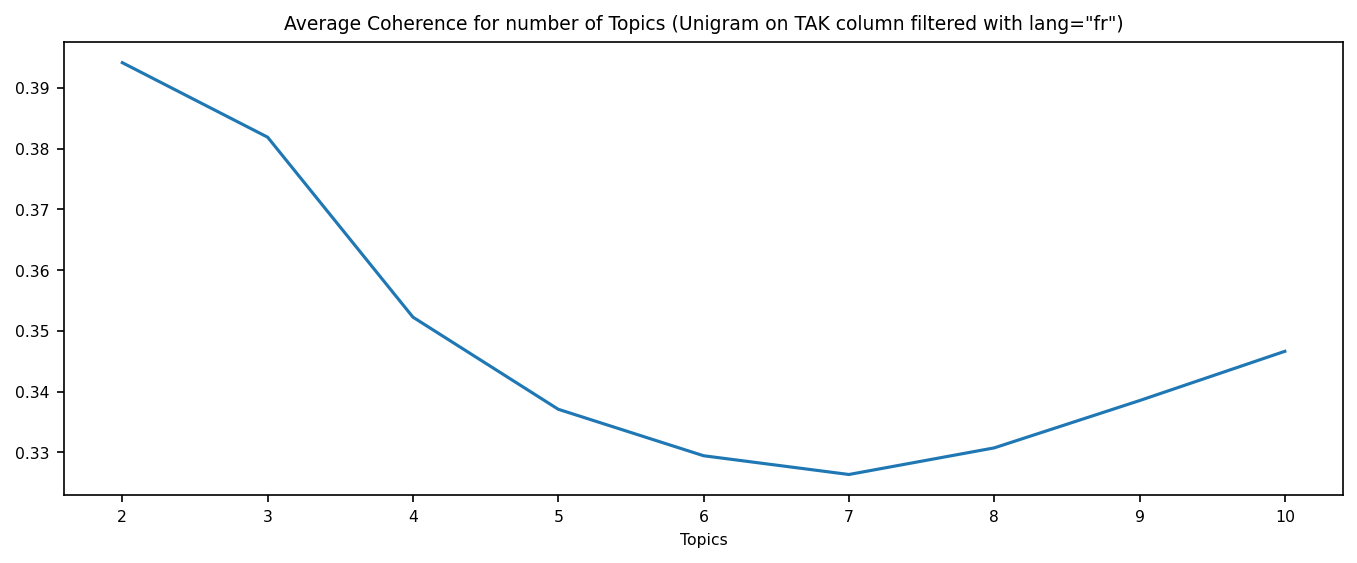

In [79]:
results.groupby(by='Topics').Coherence.mean().plot(title='Average Coherence for number of Topics (Unigram on TAK column filtered with lang="fr")')
pass

On peut alors clairement voir que la meilleure cohérence est donnée par 2 topics. Avant de faire cette étude sur 2 topics nous allons tout de même essayer avec 6 pour comparer avec notre KMeans fait précédemment. 

(Nous aurions pu aller vers les 10 topics puisque la coherence semble augmenter avec le nombre de topics à partir de 7 mais cela serait trop de topics pour une analyse simple)


#### Entrainement et Visualisation

##### 6 topics

In [80]:
%%capture

num_topics = 6
alpha = 0.61
beta = 0.61

lda_model = gensim.models.LdaMulticore(
        corpus=corpus_bow,
        id2word=corpus_dict,
        num_topics=num_topics, 
        random_state=42,
        passes=20,
        alpha=alpha,
        eta=beta
)

In [81]:
viz = pyLDAvis.gensim.prepare(lda_model, corpus_bow, corpus_dict)

# save HTML pag of visualization
vis_filename = f'LDA_FR_TAK_UNIGRAM_{num_topics}TOPICS_{alpha}ALPHA_{beta}BETA.html'
pyLDAvis.save_html(viz, os.path.join(save_dir, vis_filename))

viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.123146 -0.010814       1        1  41.242738
0      0.087733 -0.031837       2        1  29.803201
4      0.022059  0.079513       3        1  15.076115
2     -0.061140 -0.046251       4        1   5.671994
5     -0.067458  0.014172       5        1   5.393144
1     -0.104340 -0.004783       6        1   2.812807, topic_info=            Term         Freq        Total Category  logprob  loglift
35        corpus  1147.000000  1147.000000  Default  30.0000  30.0000
713   traduction   469.000000   469.000000  Default  29.0000  29.0000
57     grammaire   194.000000   194.000000  Default  28.0000  28.0000
1788  annotation   238.000000   238.000000  Default  27.0000  27.0000
247   grammaires   179.000000   179.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
2369      resume     3.023629   109.518110   Topic6  -7.0328  -0.0186
1342      regles     3.099291   180.370467   Topic6  -7.0081  -0.4929
2109   dynamique     2.520041    27.317173   Topic6  -7.2150   1.1877
2730       roles     2.540708    34.121990   Topic6  -7.2068   0.9735
204         sens     2.688245   227.464353   Topic6  -7.1503  -0.8671

[433 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
0          1  0.539922         a
0          2  0.324208         a
0          3  0.096085         a
0          4  0.017817         a
0          5  0.018135         a
...      ...       ...       ...
1818       6  0.008334       web
10154      1  0.182340  winograd
10154      2  0.182340  winograd
10154      5  0.182340  winograd
10154      6  0.547020  winograd

[1329 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 5, 3, 6, 2])

**La visualisation est disponible est exportée aussi sous format LDA\_{lang}\_{data}\_{ngram}\_{num_topics}TOPICS\_{alpha}ALPHA\_{beta}BETA.html**

En placant le lambda = 0.2, on peut alors se rendre compte de clusters assez semblables à ce que l'on avait avec KMeans. On retrouve :
- Les publications sur la traduction et sémantique 
- Les publications sur les entités nommées
- Les publications sur la grammaire
- Les publications sur les arbres qui traitent d'annotation
- Les autres clusters sont difficiles à définir. La complexité doit être trop élevée ce qui nous conforte dans le choix des 2 topics pour la LDA


##### 2 topics

In [82]:
%%capture

num_topics = 2
alpha = 0.61
beta = 0.61

lda_model = gensim.models.LdaMulticore(
        corpus=corpus_bow,
        id2word=corpus_dict,
        num_topics=num_topics, 
        random_state=42,
        passes=20,
        alpha=alpha,
        eta=beta
)

In [83]:
viz = pyLDAvis.gensim.prepare(lda_model, corpus_bow, corpus_dict)

# save HTML pag of visualization
vis_filename = f'LDA_FR_TAK_UNIGRAM_{num_topics}TOPICS_{alpha}ALPHA_{beta}BETA.html'
pyLDAvis.save_html(viz, os.path.join(save_dir, vis_filename))

viz

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.052846  0.0       1        1  64.347143
1     -0.052846  0.0       2        1  35.652857, topic_info=           Term        Freq        Total Category  logprob  loglift
713  traduction  490.000000   490.000000  Default  30.0000  30.0000
247  grammaires  214.000000   214.000000  Default  29.0000  29.0000
57    grammaire  232.000000   232.000000  Default  28.0000  28.0000
360   questions  140.000000   140.000000  Default  27.0000  27.0000
132     systeme  694.000000   694.000000  Default  26.0000  26.0000
..          ...         ...          ...      ...      ...      ...
35       corpus  189.035411  1321.994180   Topic2  -5.4369  -0.9136
81       modele  128.784551   390.407039   Topic2  -5.8207  -0.0777
170    francais  134.745811   543.661760   Topic2  -5.7755  -0.3636
624  evaluation  123.873506   430.327311   Topic2  -5.8596  -0.2139
206  syntaxique  123.635713   503.963254   Topic2  -5.8615  -0.3738

[183 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
0          1  0.676722            a
0          2  0.323358            a
235        1  0.103352   abstraites
235        2  0.930166   abstraites
588        1  0.967461  acquisition
...      ...       ...          ...
8649       2  0.025777       tweets
2674       1  0.984528      valence
2674       2  0.046882      valence
10154      1  0.113420     winograd
10154      2  0.907359     winograd

[272 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

**La visualisation est disponible est exportée aussi sous format LDA\_{lang}\_{data}\_{ngram}\_{num_topics}TOPICS\_{alpha}ALPHA\_{beta}BETA.html**

En placant le lambda = 0.2, on peut alors se rendre compte de clusters bien définis. On retrouve :
- Les publications sur les entités nommées, corpus, et analyses sémantiques
- Les publications sur la traducion automatique (et résumés), la grammaire et les questions-réponse/interfaces (chatbot)


### Francais Bigram titre-abstract-keywords




#### Bag of Words et dictionnaire de corpus

In [84]:
data = list(bigram_corpus_fr[bigram_corpus_fr.lang == 'fr'].tak)
# get the dictionary of the corpus as token ids
corpus_dict = gensim.corpora.Dictionary(data)

# get the bag-of-words (as tuple (token_id, token_count))
corpus_bow = [corpus_dict.doc2bow(word) for word in data]

#### Entrainement et Visualisation

Dans un soucis de coherence nous allons garder nos hyperparamètres :
- num_topics = 2
- alpha = 0.61
- beta = 0.61



In [85]:
%%capture

num_topics = 2
alpha = 0.61
beta = 0.61

lda_model = gensim.models.LdaMulticore(
        corpus=corpus_bow,
        id2word=corpus_dict,
        num_topics=num_topics, 
        random_state=42,
        passes=20,
        alpha=alpha,
        eta=beta
)

In [86]:
viz = pyLDAvis.gensim.prepare(lda_model, corpus_bow, corpus_dict)

# save HTML pag of visualization
vis_filename = f'LDA_FR_TAK_BIGRAM_{num_topics}TOPICS_{alpha}ALPHA_{beta}BETA.html'
pyLDAvis.save_html(viz, os.path.join(save_dir, vis_filename))

viz

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.051726  0.0       1        1  52.488015
1     -0.051726  0.0       2        1  47.511985, topic_info=                     Term       Freq      Total Category  logprob  loglift
4475         noms propres  17.000000  17.000000  Default  30.0000  30.0000
723         homme machine  42.000000  42.000000  Default  29.0000  29.0000
7898     approche hybride   9.000000   9.000000  Default  28.0000  28.0000
54157         termes cles  10.000000  10.000000  Default  27.0000  27.0000
703        dialogue homme  29.000000  29.000000  Default  26.0000  26.0000
...                   ...        ...        ...      ...      ...      ...
5956   resume automatique  20.163130  41.773423   Topic2  -7.9245   0.0158
842         partir corpus  24.913360  67.320590   Topic2  -7.7129  -0.2499
4                   a ete  23.856726  66.248365   Topic2  -7.7563  -0.2772
1471          cette etude  18.564246  36.805404   Topic2  -8.0071   0.0598
1756               a aide  22.188553  71.364459   Topic2  -7.8288  -0.4240

[186 rows x 6 columns], token_table=       Topic      Freq                  Term
term                                        
1756       1  0.686616                a aide
1756       2  0.308277                a aide
351        1  0.502822                a base
351        2  0.502822                a base
13771      2  0.995642            a ensemble
...      ...       ...                   ...
33704      1  0.871688              tt mctag
66843      2  1.030101        types discours
29898      1  0.971095  unites polylexicales
6335       1  0.809182  vecteurs conceptuels
6335       2  0.161836  vecteurs conceptuels

[211 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

**La visualisation est disponible est exportée aussi sous format LDA\_{lang}\_{data}\_{ngram}\_{num_topics}TOPICS\_{alpha}ALPHA\_{beta}BETA.html**

En placant le lambda = 0.2, on peut alors se rendre compte de clusters bien définis mais totalement différents de ceux en unigram. On retrouve :
- Toutes les approches analytiques
- Toutes les approches homme-machine

### Anglais Unigram titre-abstract-keywords




#### Bag of Words et dictionnaire de corpus

In [87]:
data = list(unigram_corpus_en[unigram_corpus_en.lang == 'en'].tak)
# get the dictionary of the corpus as token ids
corpus_dict = gensim.corpora.Dictionary(data)

# get the bag-of-words (as tuple (token_id, token_count))
corpus_bow = [corpus_dict.doc2bow(word) for word in data]

#### Entrainement et Visualisation

Dans un soucis de coherence nous allons garder nos hyperparamètres :
- num_topics = 2
- alpha = 0.61
- beta = 0.61


In [88]:
%%capture

num_topics = 2
alpha = 0.61
beta = 0.61

lda_model = gensim.models.LdaMulticore(
        corpus=corpus_bow,
        id2word=corpus_dict,
        num_topics=num_topics, 
        random_state=42,
        passes=20,
        alpha=alpha,
        eta=beta
)

In [89]:
viz = pyLDAvis.gensim.prepare(lda_model, corpus_bow, corpus_dict)

# save HTML pag of visualization
vis_filename = f'LDA_EN_TAK_UNIGRAM_{num_topics}TOPICS_{alpha}ALPHA_{beta}BETA.html'
pyLDAvis.save_html(viz, os.path.join(save_dir, vis_filename))

viz

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.065792  0.0       1        1  64.533763
1     -0.065792  0.0       2        1  35.466237, topic_info=                Term       Freq      Total Category  logprob  loglift
51              none  28.000000  28.000000  Default  30.0000  30.0000
900   disambiguation  14.000000  14.000000  Default  29.0000  29.0000
911            sense  11.000000  11.000000  Default  28.0000  28.0000
1289         finnish   8.000000   8.000000  Default  27.0000  27.0000
317        algorithm  14.000000  14.000000  Default  26.0000  26.0000
...              ...        ...        ...      ...      ...      ...
58           present   8.138357  23.553610   Topic2  -5.7594  -0.0261
625     multilingual   6.337643  12.249234   Topic2  -6.0095   0.3776
428              use   6.911780  19.892286   Topic2  -5.9228  -0.0205
37            french   6.970912  24.526773   Topic2  -5.9143  -0.2214
39           grammar   6.925884  26.856736   Topic2  -5.9208  -0.3187

[156 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
702       2  0.825815       agent
317       1  0.273290   algorithm
317       2  0.683224   algorithm
1689      1  0.983812   alignment
1844      1  0.990352  analogical
...     ...       ...         ...
2175      2  0.852033   wikipedia
73        1  0.121062      within
73        2  0.847437      within
362       1  0.607063        word
362       2  0.415359        word

[168 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

**La visualisation est disponible est exportée aussi sous format LDA\_{lang}\_{data}\_{ngram}\_{num_topics}TOPICS\_{alpha}ALPHA\_{beta}BETA.html**

En se placant toujours sur lambda = 0.2, nous avons plus de mal pour les unigram anglais à définir les deux clusters. Mais si on devait résumer tout de mêême on pourrait dire :
- Tous ce qui touche au NLP au sens large
- Les facons de faire pour que les données textuelles soient moins ambigües

Cependant il est à prendre à la légère car nous sommes avec un petit dataset de seulement 100 données alors il est difficile à analyser comparé à sa complexité dans son vocabulaire.

### Francais Unigram contenu

Et enfin pour terminer nous allons revenir sur le contenu en lui même. 
Nous ne le ferons pas en bigram ni en anglais toujours pour la raison de complexité de vocabulaire.


#### Bag of Words et dictionnaire de corpus

In [90]:
data = list(unigram_corpus_fr[unigram_corpus_fr.lang == 'fr'].content)
# get the dictionary of the corpus as token ids
corpus_dict = gensim.corpora.Dictionary(data)

# get the bag-of-words (as tuple (token_id, token_count))
corpus_bow = [corpus_dict.doc2bow(word) for word in data]

#### Entrainement et Visualisation

Oublions le soucis de cohérence et revenons à 6 topics :
- num_topics = 6
- alpha = 0.61
- beta = 0.61


In [91]:
%%capture

num_topics = 6
alpha = 0.61
beta = 0.61

lda_model = gensim.models.LdaMulticore(
        corpus=corpus_bow,
        id2word=corpus_dict,
        num_topics=num_topics, 
        random_state=42,
        passes=10,
        alpha=alpha,
        eta=beta
)

In [92]:
viz = pyLDAvis.gensim.prepare(lda_model, corpus_bow, corpus_dict)

# save HTML pag of visualization
vis_filename = f'LDA_FR_CONTENT_UNIGRAM_{num_topics}TOPICS_{alpha}ALPHA_{beta}BETA.html'
pyLDAvis.save_html(viz, os.path.join(save_dir, vis_filename))

viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.251683  0.016424       1        1  86.051110
5      0.130936 -0.037071       2        1  12.093107
0     -0.034142  0.038895       3        1   1.267224
3     -0.121032 -0.002497       4        1   0.221725
1     -0.106665 -0.011073       5        1   0.199858
4     -0.120780 -0.004677       6        1   0.166974, topic_info=         Term          Freq         Total Category  logprob  loglift
0           a  83003.000000  83003.000000  Default  30.0000  30.0000
601      plus  18121.000000  18121.000000  Default  29.0000  29.0000
588      peut   8025.000000   8025.000000  Default  28.0000  28.0000
103     cette  12859.000000  12859.000000  Default  27.0000  27.0000
812   systeme   7083.000000   7083.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
230      deux      0.830683  11742.825710   Topic6  -8.5323  -3.1614
284     entre      0.733777   9977.434724   Topic6  -8.6563  -3.1225
2629     mots      0.702396  13462.436576   Topic6  -8.7000  -3.4658
993    corpus      0.687064  16273.547512   Topic6  -8.7221  -3.6775
358     forme      0.686231   4278.357681   Topic6  -8.7233  -2.3428

[473 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
0          1  0.892419       a
0          2  0.104875       a
0          3  0.002470       a
0          4  0.000072       a
0          5  0.000108       a
...      ...       ...     ...
77073      2  0.097317  yxsfxn
77073      3  0.875857  yxsfxn
77074      1  0.111235     yxv
77074      2  0.111235     yxv
77074      3  0.889883     yxv

[976 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 1, 4, 2, 5])

**La visualisation est disponible est exportée aussi sous format LDA\_{lang}\_{data}\_{ngram}\_{num_topics}TOPICS\_{alpha}ALPHA\_{beta}BETA.html**

Avant même de placer notre lambda, on constate direcement que le nombre de topic aurait dû être placé à 2 car les quatres derniers ne sont que des cas très particuliers et la majorité se retrouve dans les deux premier clusters. 

En placant le lambda = 0.2, on peut alors faire le lien avec ce que l'on a trouvé avec nos bigram sur le titre / abstract / keyword. On retrouve :
- Toutes les approches analytiques
- Toutes les approches homme-machine

## Export du notebook

In [ ]:
# Save HTML and PDF and MD
!jupyter nbconvert --to html "/content/drive/MyDrive/A5/Advanced Machine Learning for Big Data and Text Processing/project1/project_1.ipynb" --output-dir="/content/drive/MyDrive/A5/Advanced Machine Learning for Big Data and Text Processing/project1/save_dir"
!jupyter nbconvert --to pdf "/content/drive/MyDrive/A5/Advanced Machine Learning for Big Data and Text Processing/project1/project_1.ipynb" --output-dir="/content/drive/MyDrive/A5/Advanced Machine Learning for Big Data and Text Processing/project1/save_dir"
!jupyter nbconvert --to markdown "/content/drive/MyDrive/A5/Advanced Machine Learning for Big Data and Text Processing/project1/project_1.ipynb" --output-dir="/content/drive/MyDrive/A5/Advanced Machine Learning for Big Data and Text Processing/project1/save_dir"